# Compare between different mer

# k = 3, run 10 times, 0.8691

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 3
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1852
Run 1, Epoch 2: Accuracy = 0.3951
Run 1, Epoch 3: Accuracy = 0.6173
Run 1, Epoch 4: Accuracy = 0.6790
Run 1, Epoch 5: Accuracy = 0.7284
Run 1, Epoch 6: Accuracy = 0.6420
Run 1, Epoch 7: Accuracy = 0.7284
Run 1, Epoch 8: Accuracy = 0.7407
Run 1, Epoch 9: Accuracy = 0.7531
Run 1, Epoch 10: Accuracy = 0.8148
Run 1, Epoch 11: Accuracy = 0.7778
Run 1, Epoch 12: Accuracy = 0.7901
Run 1, Epoch 13: Accuracy = 0.8395
Run 1, Epoch 14: Accuracy = 0.8642
Run 1, Epoch 15: Accuracy = 0.7407
Run 1, Epoch 16: Accuracy = 0.7901
Run 1, Epoch 17: Accuracy = 0.7531
Run 1, Epoch 18: Accuracy = 0.7654
Run 1, Epoch 19: Accuracy = 0.7654
Run 1, Epoch 20: Accuracy = 0.7531
Run 1, Epoch 21: Accuracy = 0.7778
Run 1, Epoch 22: Accuracy = 0.7778
Run 1, Epoch 23: Accuracy = 0.8519
Run 1, Epoch 24: Accuracy = 0.8642
Run 1, Epoch 25: Accuracy = 0.8025
Run 1, Epoch 26: Accuracy = 0.8272
Run 1, Epoch 27: Accuracy = 0.8519
Run 1, Epoch 28: Accuracy = 0.8642
Run 1, Epoch 29: Accuracy = 0

# K = 5, 10 times running(0.942)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 5
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1605
Run 1, Epoch 2: Accuracy = 0.3704
Run 1, Epoch 3: Accuracy = 0.6667
Run 1, Epoch 4: Accuracy = 0.8025
Run 1, Epoch 5: Accuracy = 0.8148
Run 1, Epoch 6: Accuracy = 0.7901
Run 1, Epoch 7: Accuracy = 0.7901
Run 1, Epoch 8: Accuracy = 0.7778
Run 1, Epoch 9: Accuracy = 0.8395
Run 1, Epoch 10: Accuracy = 0.8148
Run 1, Epoch 11: Accuracy = 0.7778
Run 1, Epoch 12: Accuracy = 0.7531
Run 1, Epoch 13: Accuracy = 0.8642
Run 1, Epoch 14: Accuracy = 0.8272
Run 1, Epoch 15: Accuracy = 0.7901
Run 1, Epoch 16: Accuracy = 0.8642
Run 1, Epoch 17: Accuracy = 0.8519
Run 1, Epoch 18: Accuracy = 0.9012
Run 1, Epoch 19: Accuracy = 0.8025
Run 1, Epoch 20: Accuracy = 0.8765
Run 1, Epoch 21: Accuracy = 0.9259
Run 1, Epoch 22: Accuracy = 0.9630
Run 1, Epoch 23: Accuracy = 0.7778
Run 1, Epoch 24: Accuracy = 0.9136
Run 1, Epoch 25: Accuracy = 0.8148
Run 1, Epoch 26: Accuracy = 0.8765
Run 1, Epoch 27: Accuracy = 0.8519
Run 1, Epoch 28: Accuracy = 0.8272
Run 1, Epoch 29: Accuracy = 0

# K = 6, 10 times running(0.9519)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1605
Run 1, Epoch 2: Accuracy = 0.4444
Run 1, Epoch 3: Accuracy = 0.6790
Run 1, Epoch 4: Accuracy = 0.8272
Run 1, Epoch 5: Accuracy = 0.7778
Run 1, Epoch 6: Accuracy = 0.8765
Run 1, Epoch 7: Accuracy = 0.8642
Run 1, Epoch 8: Accuracy = 0.8272
Run 1, Epoch 9: Accuracy = 0.8395
Run 1, Epoch 10: Accuracy = 0.8765
Run 1, Epoch 11: Accuracy = 0.8395
Run 1, Epoch 12: Accuracy = 0.8272
Run 1, Epoch 13: Accuracy = 0.8272
Run 1, Epoch 14: Accuracy = 0.8025
Run 1, Epoch 15: Accuracy = 0.8025
Run 1, Epoch 16: Accuracy = 0.8272
Run 1, Epoch 17: Accuracy = 0.9383
Run 1, Epoch 18: Accuracy = 0.8272
Run 1, Epoch 19: Accuracy = 0.8519
Run 1, Epoch 20: Accuracy = 0.8272
Run 1, Epoch 21: Accuracy = 0.8765
Run 1, Epoch 22: Accuracy = 0.8519
Run 1, Epoch 23: Accuracy = 0.8519
Run 1, Epoch 24: Accuracy = 0.8395
Run 1, Epoch 25: Accuracy = 0.9012
Run 1, Epoch 26: Accuracy = 0.8395
Run 1, Epoch 27: Accuracy = 0.8025
Run 1, Epoch 28: Accuracy = 0.8395
Run 1, Epoch 29: Accuracy = 0

# k=3, filter to 5, run 10 times, 0.668

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 3
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0607
Run 1, Epoch 2: Accuracy = 0.1660
Run 1, Epoch 3: Accuracy = 0.2632
Run 1, Epoch 4: Accuracy = 0.3360
Run 1, Epoch 5: Accuracy = 0.4291
Run 1, Epoch 6: Accuracy = 0.4696
Run 1, Epoch 7: Accuracy = 0.5182
Run 1, Epoch 8: Accuracy = 0.5061
Run 1, Epoch 9: Accuracy = 0.5344
Run 1, Epoch 10: Accuracy = 0.5628
Run 1, Epoch 11: Accuracy = 0.5506
Run 1, Epoch 12: Accuracy = 0.4939
Run 1, Epoch 13: Accuracy = 0.5668
Run 1, Epoch 14: Accuracy = 0.5547
Run 1, Epoch 15: Accuracy = 0.5506
Run 1, Epoch 16: Accuracy = 0.5223
Run 1, Epoch 17: Accuracy = 0.4899
Run 1, Epoch 18: Accuracy = 0.5668
Run 1, Epoch 19: Accuracy = 0.5668
Run 1, Epoch 20: Accuracy = 0.5668
Run 1, Epoch 21: Accuracy = 0.5304
Run 1, Epoch 22: Accuracy = 0.5951
Run 1, Epoch 23: Accuracy = 0.6154
Run 1, Epoch 24: Accuracy = 0.6154
Run 1, Epoch 25: Accuracy = 0.5668
Run 1, Epoch 26: Accuracy = 0.5223
Run 1, Epoch 27: Accuracy = 0.5587
Run 1, Epoch 28: Accuracy = 0.5142
Run 1, Epoch 29: Accuracy = 0

# k=5, filter to 5, run 10 times, (0.7547)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 5
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0526
Run 1, Epoch 2: Accuracy = 0.1538
Run 1, Epoch 3: Accuracy = 0.2551
Run 1, Epoch 4: Accuracy = 0.3725
Run 1, Epoch 5: Accuracy = 0.4413
Run 1, Epoch 6: Accuracy = 0.5547
Run 1, Epoch 7: Accuracy = 0.5668
Run 1, Epoch 8: Accuracy = 0.5506
Run 1, Epoch 9: Accuracy = 0.5830
Run 1, Epoch 10: Accuracy = 0.6032
Run 1, Epoch 11: Accuracy = 0.6437
Run 1, Epoch 12: Accuracy = 0.6073
Run 1, Epoch 13: Accuracy = 0.6559
Run 1, Epoch 14: Accuracy = 0.6599
Run 1, Epoch 15: Accuracy = 0.6721
Run 1, Epoch 16: Accuracy = 0.5951
Run 1, Epoch 17: Accuracy = 0.6356
Run 1, Epoch 18: Accuracy = 0.5668
Run 1, Epoch 19: Accuracy = 0.6194
Run 1, Epoch 20: Accuracy = 0.6275
Run 1, Epoch 21: Accuracy = 0.6275
Run 1, Epoch 22: Accuracy = 0.5385
Run 1, Epoch 23: Accuracy = 0.5951
Run 1, Epoch 24: Accuracy = 0.6154
Run 1, Epoch 25: Accuracy = 0.6518
Run 1, Epoch 26: Accuracy = 0.6721
Run 1, Epoch 27: Accuracy = 0.6356
Run 1, Epoch 28: Accuracy = 0.6518
Run 1, Epoch 29: Accuracy = 0

# k=6, filter to 5, run 10 times(0.7704)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0445
Run 1, Epoch 2: Accuracy = 0.1093
Run 1, Epoch 3: Accuracy = 0.2065
Run 1, Epoch 4: Accuracy = 0.2915
Run 1, Epoch 5: Accuracy = 0.4453
Run 1, Epoch 6: Accuracy = 0.5101
Run 1, Epoch 7: Accuracy = 0.5304
Run 1, Epoch 8: Accuracy = 0.6113
Run 1, Epoch 9: Accuracy = 0.5911
Run 1, Epoch 10: Accuracy = 0.6316
Run 1, Epoch 11: Accuracy = 0.6518
Run 1, Epoch 12: Accuracy = 0.6640
Run 1, Epoch 13: Accuracy = 0.6802
Run 1, Epoch 14: Accuracy = 0.6883
Run 1, Epoch 15: Accuracy = 0.6640
Run 1, Epoch 16: Accuracy = 0.6640
Run 1, Epoch 17: Accuracy = 0.7085
Run 1, Epoch 18: Accuracy = 0.6518
Run 1, Epoch 19: Accuracy = 0.6478
Run 1, Epoch 20: Accuracy = 0.6761
Run 1, Epoch 21: Accuracy = 0.6640
Run 1, Epoch 22: Accuracy = 0.7166
Run 1, Epoch 23: Accuracy = 0.6680
Run 1, Epoch 24: Accuracy = 0.7206
Run 1, Epoch 25: Accuracy = 0.7409
Run 1, Epoch 26: Accuracy = 0.6883
Run 1, Epoch 27: Accuracy = 0.7530
Run 1, Epoch 28: Accuracy = 0.7449
Run 1, Epoch 29: Accuracy = 0

# aa


Let's mathematically evaluate how to choose the optimal k-mer length for DNA sequences of approximately 750 nucleotides.

### Step-by-step Mathematical Reasoning:

Given:

- DNA sequence length \( L \approx 750 \text{ nucleotides} \).

- DNA is composed of 4 nucleotides: \(\{A, T, C, G\}\).

---

## Step 1: Calculate the number of possible k-mers:

- For a k-mer of length \(k\), the number of possible combinations is:
\[
4^k
\]

| k-mer length (k) | Number of combinations (4^k) |
|------------------|------------------------------|
| 3                | \(4^3 = 64\)                   |
| 4                | \(4^4 = 256\)                  |
| 5                | \(4^5 = 1024\)                 |
| 6                | \(4^6 = 4096\)                 |
| 7                | \(4^7 = 16384\)                |

---

## Step 2: Calculate the number of k-mers in a sequence of length 750:

- For a sequence of length \(L\), the number of k-mers generated is approximately:
\[
L - k + 1 \approx L - k
\]

For \(L=750\):

| k-mer length (k) | Number of k-mers per sequence |
|------------------|-------------------------------|
| 4                | \(750 - 4 + 1 = 747\)          |
| 5                | \(750 - 5 + 1 = 746\)          |
| 6                | \(750 - 6 + 1 = 745\)          |
| 7                | \(750 - 7 + 1 = 744\)          |

(Approximately equal numbers.)

---

## Step 3: Calculate Expected Occurrences per k-mer:

- The expected frequency of each unique k-mer, if uniformly random, is approximately:
\[
\text{Frequency per k-mer} = \frac{\text{Total k-mers in sequence}}{4^k}
\]

| k-mer length (k) | Frequency per unique k-mer     |
|------------------|--------------------------------|
| 4                | \(747 / 256 \approx 2.918\)     |
| 5                | \(746 / 1024 \approx 0.729\)    |
| 6                | \(745 / 4096 \approx 0.182\)    |
| 7                | \(744 / 16384 \approx 0.045\)   |

---

## Analysis of Results:

- **k = 4:**  
  - Each unique 4-mer appears ~3 times on average per sequence.
  - Might be too frequent to distinguish meaningful motifs clearly; could generate noise.

- **k = 5**:
  - Each unique 5-mer appears ~0.73 times per sequence (once every ~1.37 sequences).
  - Good balance between capturing recurring motifs without excessive repetition or sparsity.

- **k = 6**:
  - Each unique 6-mer appears ~0.18 times per sequence (approximately once every ~5.5 sequences).
  - Sparse but manageable, good for identifying distinct patterns in larger datasets.

- **k = 7**:
  - Each unique 7-mer appears ~0.045 times per sequence (once every ~22 sequences).
  - Potentially too sparse for effective motif detection unless you have a very large dataset.

---

## Recommended Choice (Mathematically Justified):

- **5-mers (k=5)** provide a balanced frequency (about one occurrence per sequence) to capture clear, distinguishable motifs without excessive sparsity or redundancy.

- **6-mers** could also be good if your analysis focuses on more specific motifs, and your dataset is sufficiently large.

Thus, the mathematically optimal k-mer for DNA sequences of around 750 nucleotides would typically be:

\[
\boxed{k = 5 \text{ or } k = 6}
\]

Would you like to analyze this further with actual data distributions?

# CNN run 10 times, with resamplnig distillation ..., same as in vit, 82.35


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 9.9799 | Test Acc: 4.94%
Epoch 2/100 | Loss: 3.0105 | Test Acc: 28.40%
Epoch 3/100 | Loss: 1.6497 | Test Acc: 48.15%
Epoch 4/100 | Loss: 0.8692 | Test Acc: 70.37%
Epoch 5/100 | Loss: 0.4665 | Test Acc: 71.60%
Epoch 6/100 | Loss: 0.3240 | Test Acc: 74.07%
Epoch 7/100 | Loss: 0.2361 | Test Acc: 81.48%
Epoch 8/100 | Loss: 0.2306 | Test Acc: 72.84%
Epoch 9/100 | Loss: 0.1808 | Test Acc: 72.84%
Epoch 10/100 | Loss: 0.1506 | Test Acc: 75.31%
Epoch 11/100 | Loss: 0.1487 | Test Acc: 80.25%
Epoch 12/100 | Loss: 0.1072 | Test Acc: 77.78%
Epoch 13/100 | Loss: 0.1522 | Test Acc: 76.54%
Epoch 14/100 | Loss: 0.1159 | Test Acc: 79.01%
Epoch 15/100 | Loss: 0.1227 | Test Acc: 80.25%
Epoch 16/100 | Loss: 0.1159 | Test Acc: 79.01%
Epoch 17/100 | Loss: 0.1113 | Test Acc: 80.25%
Early stopping at epoch 17
Run 1 

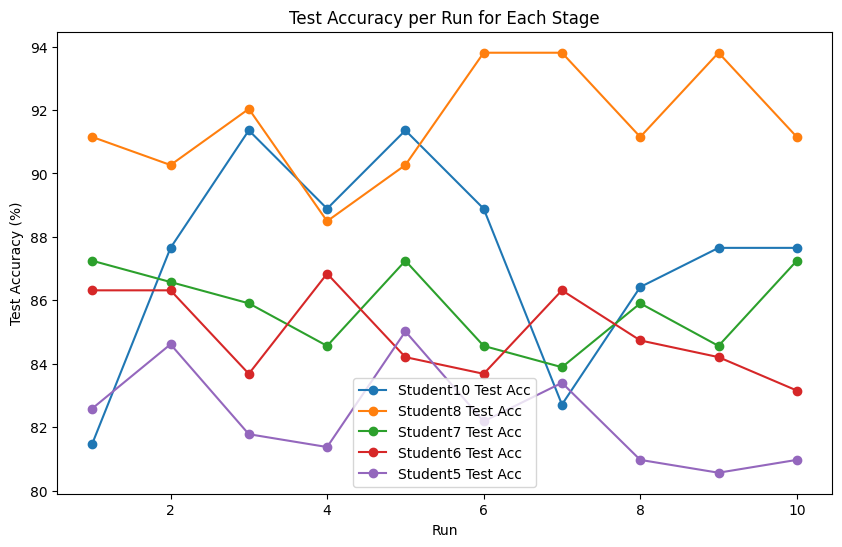

Student10: 87.41%
Student8: 91.59%
Student7: 85.77%
Student6: 84.95%
Student5: 82.35%


In [11]:
import os
import math
import random
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
# We will not use the originally filtered_vector_file since we need to filter differently per stage.
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    # Each line is of the form: ">label<TAB>vec0 vec1 ..."
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return vector as float tensor and label as long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x has shape (batch_size, input_dim); add channel dimension.
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]  # [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # [B, num_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Main multi-stage training pipeline
##########################################
# First, load the raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We will store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# To hold teacher models for distillation between stages.
# For stage 1 (Student 10) there is no teacher.
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation
temperature = 4.5
alpha = 0.5

# A dictionary to store best average accuracy for each stage.
stage_avg_acc = {}

# Stages and corresponding minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    # Filter data based on min_count.
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling to training data.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Get labels and vectors.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create a label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    # Create a label-to-index dictionary.
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders.
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    # For multi-run experiments.
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                # For others, combine with distillation loss.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    # Get teacher logits.
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # Compute cross-entropy loss.
                    ce_loss = criterion(outputs, labels)
                    # Get overlapping classes indices.
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    # For Student7, use focal loss for classification.
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            # Evaluation on test set.
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state.
        model.load_state_dict(best_state)
        # Freeze model parameters.
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        print(f"Run {run+1} Best Test Accuracy: {best_acc:.2f}%")
        run_accs.append(best_acc)
    
    avg_stage_acc = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage_acc
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage_acc:.2f}% ***")
    
    # Set teacher for next stage (if any)
    teacher_model = model
    teacher_label2idx = student_label2idx

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name in stages:
    name = stage_name[0]
    plt.plot(range(1, num_runs+1), stage_test_accs[name], marker='o', label=f"{name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

# Print average accuracies per stage.
for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# compare accuracy(and delta accuracy) between class, before distillation and after

# before

# k=5, 10


























Run 1, Epoch 1: Accuracy = 0.1728 (Epoch Time: 0.35 sec)
Run 1, Epoch 2: Accuracy = 0.3827 (Epoch Time: 0.33 sec)
Run 1, Epoch 3: Accuracy = 0.5309 (Epoch Time: 0.31 sec)
Run 1, Epoch 4: Accuracy = 0.8025 (Epoch Time: 0.31 sec)
Run 1, Epoch 5: Accuracy = 0.8889 (Epoch Time: 0.32 sec)
Run 1, Epoch 6: Accuracy = 0.9136 (Epoch Time: 0.31 sec)
Run 1, Epoch 7: Accuracy = 0.9012 (Epoch Time: 0.31 sec)
Run 1, Epoch 8: Accuracy = 0.9012 (Epoch Time: 0.31 sec)
Run 1, Epoch 9: Accuracy = 0.9012 (Epoch Time: 0.31 sec)
Run 1, Epoch 10: Accuracy = 0.9012 (Epoch Time: 0.32 sec)
Run 1, Epoch 11: Accuracy = 0.8765 (Epoch Time: 0.32 sec)
Run 1, Epoch 12: Accuracy = 0.8765 (Epoch Time: 0.32 sec)
Run 1, Epoch 13: Accuracy = 0.8765 (Epoch Time: 0.31 sec)
Run 1, Epoch 14: Accuracy = 0.9136 (Epoch Time: 0.31 sec)
Run 1, Epoch 15: Accuracy = 0.8395 (Epoch Time: 0.31 sec)
Run 1, Epoch 16: Accuracy = 0.8519 (Epoch Time: 0.32 sec)
Run 1, Epoch 17: Accuracy = 0.6543 (Epoch Time: 0.32 sec)
Run 1, Epoch 18: Accura

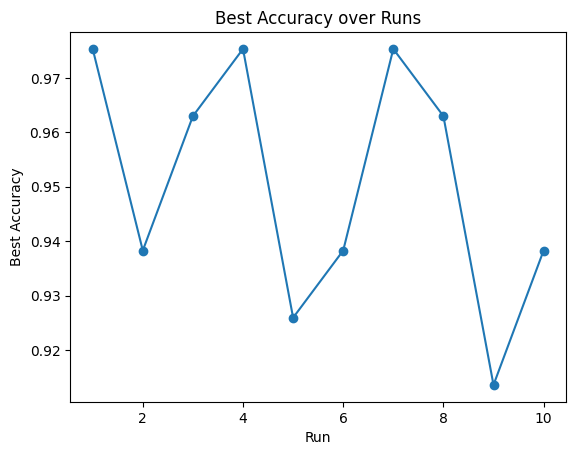

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# Constants
k = 5
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions for k-mer vectorization
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# Dataset class
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# CNN Model (using 1D convolutions)
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Partition Evaluation Function
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# Step 1: Clean FASTA headers
# -------------------------------
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# -------------------------------
# Step 2: k-mer vectorization
# -------------------------------
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# -------------------------------
# Step 3: Filter sequences by genus frequency
# -------------------------------
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# -------------------------------
# Main Experiment Loop
# -------------------------------
best_accuracies = []
# (Optional) You may store additional stage-wise results if needed.
# For timing purposes, we measure per-run duration.
for run in range(num_runs):
    run_start_time = time.time()  # Run timing starts

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop with epoch timing
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for this epoch
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels.cpu().numpy())
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state using deep copy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]
            
    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best model state (if needed)
    if best_state is not None:
        model.load_state_dict(best_state)
    
    # Partition Evaluation using the dedicated function
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy over runs.
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# (Optional) Plotting the best accuracy from each run.
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# k=6, 10

Run 1, Epoch 1: Accuracy = 0.1358 (Epoch Time: 1.28 sec)
Run 1, Epoch 2: Accuracy = 0.3951 (Epoch Time: 1.03 sec)
Run 1, Epoch 3: Accuracy = 0.5432 (Epoch Time: 1.04 sec)
Run 1, Epoch 4: Accuracy = 0.7037 (Epoch Time: 1.04 sec)
Run 1, Epoch 5: Accuracy = 0.8148 (Epoch Time: 1.04 sec)
Run 1, Epoch 6: Accuracy = 0.7778 (Epoch Time: 1.03 sec)
Run 1, Epoch 7: Accuracy = 0.8395 (Epoch Time: 1.02 sec)
Run 1, Epoch 8: Accuracy = 0.8519 (Epoch Time: 1.02 sec)
Run 1, Epoch 9: Accuracy = 0.8272 (Epoch Time: 1.01 sec)
Run 1, Epoch 10: Accuracy = 0.8272 (Epoch Time: 1.01 sec)
Run 1, Epoch 11: Accuracy = 0.8642 (Epoch Time: 1.01 sec)
Run 1, Epoch 12: Accuracy = 0.8395 (Epoch Time: 1.01 sec)
Run 1, Epoch 13: Accuracy = 0.9136 (Epoch Time: 1.01 sec)
Run 1, Epoch 14: Accuracy = 0.8148 (Epoch Time: 1.01 sec)
Run 1, Epoch 15: Accuracy = 0.8889 (Epoch Time: 1.01 sec)
Run 1, Epoch 16: Accuracy = 0.8519 (Epoch Time: 1.02 sec)
Run 1, Epoch 17: Accuracy = 0.8889 (Epoch Time: 1.02 sec)
Run 1, Epoch 18: Accura

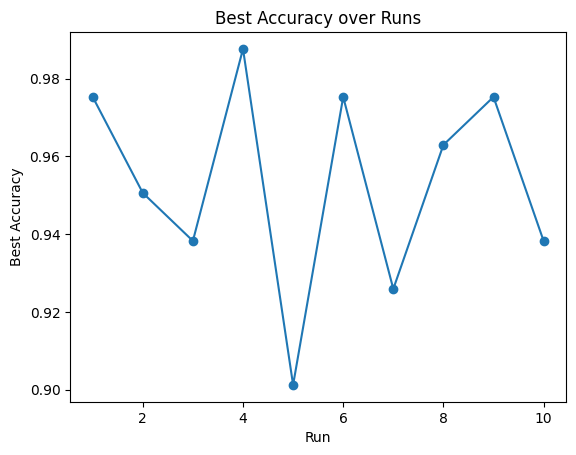

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions for k-mer vectorization
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# Dataset class
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# CNN Model (using 1D convolutions)
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Partition Evaluation Function
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# Step 1: Clean FASTA headers
# -------------------------------
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# -------------------------------
# Step 2: k-mer vectorization
# -------------------------------
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# -------------------------------
# Step 3: Filter sequences by genus frequency
# -------------------------------
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# -------------------------------
# Main Experiment Loop
# -------------------------------
best_accuracies = []
# (Optional) You may store additional stage-wise results if needed.
# For timing purposes, we measure per-run duration.
for run in range(num_runs):
    run_start_time = time.time()  # Run timing starts

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop with epoch timing
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for this epoch
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels.cpu().numpy())
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state using deep copy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]
            
    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best model state (if needed)
    if best_state is not None:
        model.load_state_dict(best_state)
    
    # Partition Evaluation using the dedicated function
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy over runs.
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# (Optional) Plotting the best accuracy from each run.
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# k=5, 5

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Run 1, Epoch 1: Accuracy = 0.0445 (Epoch Time: 0.91 sec)
Run 1, Epoch 2: Accuracy = 0.1255 (Epoch Time: 0.51 sec)
Run 1, Epoch 3: Accuracy = 0.2227 (Epoch Time: 0.50 sec)
Run 1, Epoch 4: Accuracy = 0.3968 (Epoch Time: 0.50 sec)
Run 1, Epoch 5: Accuracy = 0.4049 (Epoch Time: 0.51 sec)
Run 1, Epoch 6: Accuracy = 0.4899 (Epoch Time: 0.49 sec)
Run 1, Epoch 7: Accuracy = 0.5789 (Epoch Time: 0.49 sec)
Run 1, Epoch 8: Accuracy = 0.5789 (Epoch Time: 0.49 sec)
Run 1, Epoch 9: Accuracy = 0.5992 (Epoch Time: 0.50 sec)
Run 1, Epoch 10: Accuracy = 0.5668 (Epoch Time: 0.50 sec)
Run 1, Epoch 11: Accuracy = 0.6073 (Epoch Time: 0.52 sec)
Run 1, Epoch 12: Accuracy = 0.6397 (Epoch Time: 0.54 sec)
Run 1, Epoch 13: Accuracy = 0.6275 (Epoch Time: 0.53 sec)
Run 1, Epoch 14: Accuracy = 0.6032 (Epoch Time: 0.49 sec)
Run 1, Epoch 15: Accuracy = 0.6194 (Epoch Time: 0.49 sec)
Run 1, Epoch 16: Accuracy = 0.6235 (Epoch Time: 0.48 sec)
Run 1, Epoch 17: Accuracy = 0.6316 (Epoch Time: 0.49 sec)
Run 1, Epoch 18: Accura

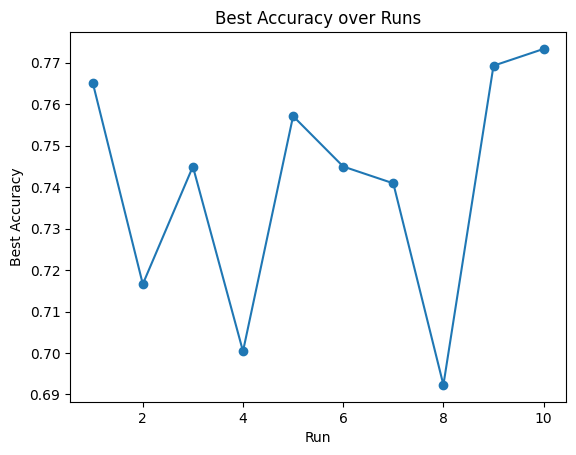

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# Constants
k = 5
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions for k-mer vectorization
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# Dataset class
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# CNN Model (using 1D convolutions)
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Partition Evaluation Function
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# Step 1: Clean FASTA headers
# -------------------------------
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# -------------------------------
# Step 2: k-mer vectorization
# -------------------------------
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# -------------------------------
# Step 3: Filter sequences by genus frequency
# -------------------------------
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# -------------------------------
# Main Experiment Loop
# -------------------------------
best_accuracies = []
# (Optional) You may store additional stage-wise results if needed.
# For timing purposes, we measure per-run duration.
for run in range(num_runs):
    run_start_time = time.time()  # Run timing starts

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop with epoch timing
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for this epoch
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels.cpu().numpy())
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state using deep copy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]
            
    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best model state (if needed)
    if best_state is not None:
        model.load_state_dict(best_state)
    
    # Partition Evaluation using the dedicated function
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy over runs.
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# (Optional) Plotting the best accuracy from each run.
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# k=6, 5          77.25

Run 1, Epoch 1: Accuracy = 0.0324 (Epoch Time: 1.86 sec)
Run 1, Epoch 2: Accuracy = 0.0810 (Epoch Time: 1.59 sec)
Run 1, Epoch 3: Accuracy = 0.2065 (Epoch Time: 1.59 sec)
Run 1, Epoch 4: Accuracy = 0.3482 (Epoch Time: 1.57 sec)
Run 1, Epoch 5: Accuracy = 0.4413 (Epoch Time: 1.56 sec)
Run 1, Epoch 6: Accuracy = 0.5385 (Epoch Time: 1.56 sec)
Run 1, Epoch 7: Accuracy = 0.5304 (Epoch Time: 1.55 sec)
Run 1, Epoch 8: Accuracy = 0.6073 (Epoch Time: 1.56 sec)
Run 1, Epoch 9: Accuracy = 0.5911 (Epoch Time: 1.55 sec)
Run 1, Epoch 10: Accuracy = 0.5911 (Epoch Time: 1.56 sec)
Run 1, Epoch 11: Accuracy = 0.6113 (Epoch Time: 1.56 sec)
Run 1, Epoch 12: Accuracy = 0.5709 (Epoch Time: 1.55 sec)
Run 1, Epoch 13: Accuracy = 0.5911 (Epoch Time: 1.56 sec)
Run 1, Epoch 14: Accuracy = 0.6032 (Epoch Time: 1.56 sec)
Run 1, Epoch 15: Accuracy = 0.5951 (Epoch Time: 1.56 sec)
Run 1, Epoch 16: Accuracy = 0.6275 (Epoch Time: 1.56 sec)
Run 1, Epoch 17: Accuracy = 0.6559 (Epoch Time: 1.55 sec)
Run 1, Epoch 18: Accura

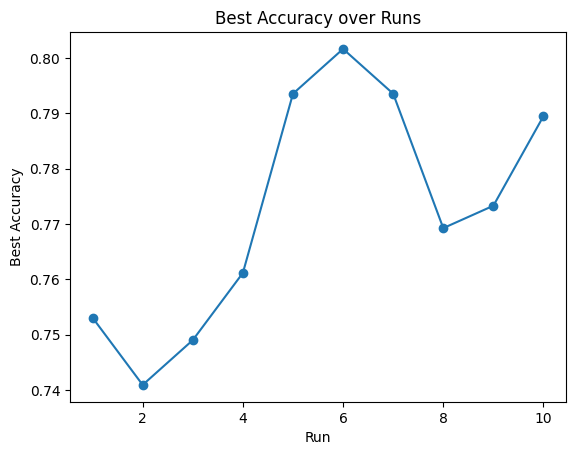

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions for k-mer vectorization
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# Dataset class
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# CNN Model (using 1D convolutions)
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Partition Evaluation Function
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# Step 1: Clean FASTA headers
# -------------------------------
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# -------------------------------
# Step 2: k-mer vectorization
# -------------------------------
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# -------------------------------
# Step 3: Filter sequences by genus frequency
# -------------------------------
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# -------------------------------
# Main Experiment Loop
# -------------------------------
best_accuracies = []
# (Optional) You may store additional stage-wise results if needed.
# For timing purposes, we measure per-run duration.
for run in range(num_runs):
    run_start_time = time.time()  # Run timing starts

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop with epoch timing
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for this epoch
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels.cpu().numpy())
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state using deep copy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]
            
    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best model state (if needed)
    if best_state is not None:
        model.load_state_dict(best_state)
    
    # Partition Evaluation using the dedicated function
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy over runs.
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# (Optional) Plotting the best accuracy from each run.
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# after, 82.75


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 6.6920 | Test Acc: 8.64% | Time: 2.74 sec
Epoch 2/100 | Loss: 2.9451 | Test Acc: 29.63% | Time: 2.59 sec
Epoch 3/100 | Loss: 1.7717 | Test Acc: 45.68% | Time: 2.48 sec
Epoch 4/100 | Loss: 1.0284 | Test Acc: 55.56% | Time: 2.48 sec
Epoch 5/100 | Loss: 0.5865 | Test Acc: 61.73% | Time: 2.47 sec
Epoch 6/100 | Loss: 0.4816 | Test Acc: 77.78% | Time: 2.46 sec
Epoch 7/100 | Loss: 0.3288 | Test Acc: 82.72% | Time: 2.46 sec
Epoch 8/100 | Loss: 0.3022 | Test Acc: 80.25% | Time: 2.47 sec
Epoch 9/100 | Loss: 0.2320 | Test Acc: 77.78% | Time: 2.46 sec
Epoch 10/100 | Loss: 0.1830 | Test Acc: 83.95% | Time: 2.46 sec
Epoch 11/100 | Loss: 0.1614 | Test Acc: 81.48% | Time: 2.46 sec
Epoch 12/100 | Loss: 0.1737 | Test Acc: 87.65% | Time: 2.46 sec
Epoch 13/100 | Loss: 0.1050 | Test Acc: 90.12% | Time: 2.47 sec


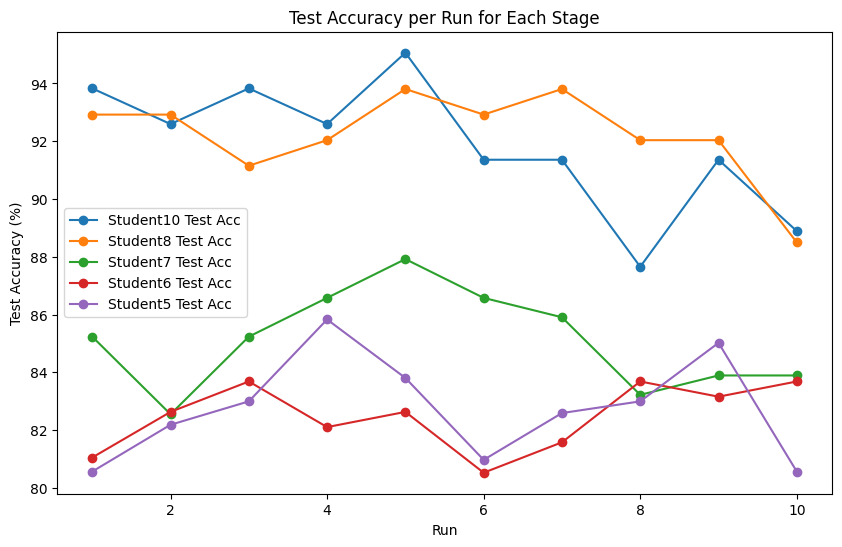

Student10: 91.85%
Student8: 92.21%
Student7: 85.10%
Student6: 82.47%
Student5: 82.75%


In [7]:
import os
import math
import random
import copy
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
# We will filter data per stage later.
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Partition Evaluation Function
##########################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

##########################################
# Main multi-stage training pipeline
##########################################
# Load raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We'll use the raw_data_all for stage filtering.
# Also store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Teacher variables (for distillation between stages).
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy per stage.
stage_avg_acc = {}

# Stages with minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

# For partition evaluation, we need the overall genus counts.
genera_count = Counter([label for label, _ in raw_data_all])

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Extract vectors and labels.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders (batch size set to 16).
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        best_preds = None
        best_trues = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                # For others, combine with distillation loss.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    # For Student7, optionally use focal loss.
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            
            # Evaluate on test set.
            model.eval()
            correct, total = 0, 0
            epoch_preds = []
            epoch_trues = []
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                    epoch_preds.extend(predicted.cpu().numpy())
                    epoch_trues.extend(labels.cpu().numpy())
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            # Replace best model and its partition predictions if test accuracy improves.
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = copy.deepcopy(model.state_dict())
                best_preds = epoch_preds[:]
                best_trues = epoch_trues[:]
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state and re-evaluate test set using best model.
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        correct, total = 0, 0
        best_preds = []
        best_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                best_preds.extend(predicted.cpu().numpy())
                best_trues.extend(labels.cpu().numpy())
        best_test_acc = 100.0 * correct / total
        print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}%")
        run_accs.append(best_test_acc)
        
        # --- Partition Evaluation using best model predictions --- 
        true_genus = label_encoder.inverse_transform(best_trues)
        pred_genus = label_encoder.inverse_transform(best_preds)
        print(f"\nPartition evaluation for {stage_name} Run {run+1}:")
        evaluate_partitions(true_genus, pred_genus, genera_count)
    
    avg_stage = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage:.2f}% ***")
    
    # Set teacher model for next stage.
    teacher_model = model
    teacher_label2idx = student_label2idx

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, accs in stage_test_accs.items():
    plt.plot(range(1, num_runs+1), accs, marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# before


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 7.6609 | Test Acc: 8.64% | Time: 2.53 sec
Epoch 2/100 | Loss: 2.7743 | Test Acc: 19.75% | Time: 2.30 sec
Epoch 3/100 | Loss: 1.6341 | Test Acc: 48.15% | Time: 2.29 sec
Epoch 4/100 | Loss: 0.9505 | Test Acc: 67.90% | Time: 2.31 sec
Epoch 5/100 | Loss: 0.5587 | Test Acc: 77.78% | Time: 2.30 sec
Epoch 6/100 | Loss: 0.3868 | Test Acc: 71.60% | Time: 2.31 sec
Epoch 7/100 | Loss: 0.3159 | Test Acc: 80.25% | Time: 2.29 sec
Epoch 8/100 | Loss: 0.2689 | Test Acc: 83.95% | Time: 2.27 sec
Epoch 9/100 | Loss: 0.2323 | Test Acc: 74.07% | Time: 2.26 sec
Epoch 10/100 | Loss: 0.2083 | Test Acc: 77.78% | Time: 2.27 sec
Epoch 11/100 | Loss: 0.1816 | Test Acc: 88.89% | Time: 2.26 sec
Epoch 12/100 | Loss: 0.1808 | Test Acc: 77.78% | Time: 2.28 sec
Epoch 13/100 | Loss: 0.1913 | Test Acc: 80.25% | Time: 2.28 sec


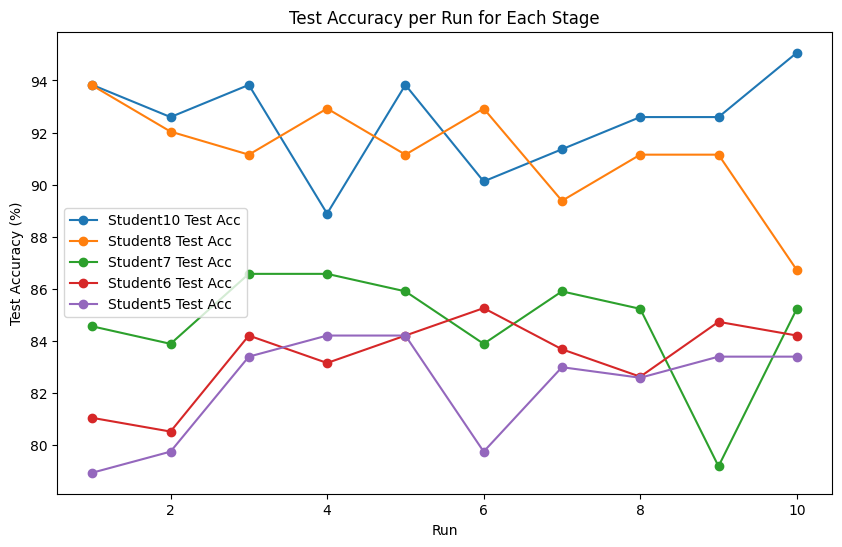

Student10: 92.47%
Student8: 91.24%
Student7: 84.70%
Student6: 83.37%
Student5: 82.27%


In [11]:
import os
import math
import random
import copy
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

# Updated distillation loss function:
def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def distillation_loss_sigmoid(student_logits, teacher_logits, student_overlap, teacher_overlap, teacher_acc, T=4.5, clip_min=0.9, clip_max=0.8, k=0.3, c=85):
    sigmoid_value = 1.0 / (1.0 + math.exp(-k * (teacher_acc - c)))
    clip_threshold = clip_min + (clip_max - clip_min) * sigmoid_value

    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Partition Evaluation Function
##########################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

##########################################
# Main multi-stage training pipeline
##########################################
raw_data_all = parse_kmer_vector_file(kmer_vector_file)
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

teacher_model = None
teacher_label2idx = None
temperature = 4.5
alpha = 0.5
stage_avg_acc = {}
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]
genera_count = Counter([label for label, _ in raw_data_all])
teacher_acc = 90.0  # placeholder teacher accuracy

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    
                    if stage_name == "Student6":
                        loss_kd = distillation_loss_sigmoid(
                            student_logits=outputs,
                            teacher_logits=teacher_outputs,
                            student_overlap=student_overlap,
                            teacher_overlap=teacher_overlap,
                            teacher_acc=teacher_acc,
                            T=temperature,
                            clip_min=0.85,
                            clip_max=0.9,
                            k=0.1,
                            c=teacher_acc
                        )
                        loss = alpha * loss_kd + (1 - alpha) * ce_loss
                    else:
                        kd_loss = distillation_loss(
                            outputs, teacher_outputs,
                            student_overlap, teacher_overlap,
                            temperature, clip_threshold=0.9
                        )
                        if stage_name == "Student7":
                            cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                        else:
                            cls_loss = ce_loss
                        loss = alpha * kd_loss + (1 - alpha) * cls_loss
                        
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            
            model.eval()
            correct, total = 0, 0
            epoch_preds = []
            epoch_trues = []
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                    epoch_preds.extend(predicted.cpu().numpy())
                    epoch_trues.extend(labels.cpu().numpy())
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        correct, total = 0, 0
        best_preds = []
        best_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                best_preds.extend(predicted.cpu().numpy())
                best_trues.extend(labels.cpu().numpy())
        best_test_acc = 100.0 * correct / total
        print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}%")
        run_accs.append(best_test_acc)
        
        true_genus = label_encoder.inverse_transform(best_trues)
        pred_genus = label_encoder.inverse_transform(best_preds)
        print(f"\nPartition evaluation for {stage_name} Run {run+1}:")
        evaluate_partitions(true_genus, pred_genus, genera_count)
        
        teacher_model = model
        teacher_label2idx = student_label2idx
        teacher_acc = best_test_acc
        
    avg_stage = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage:.2f}% ***")
    
##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, accs in stage_test_accs.items():
    plt.plot(range(1, num_runs+1), accs, marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# logistic distillation, on student6, up to 85.53


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 5.8826 | Test Acc: 6.17% | Time: 2.47 sec
Epoch 2/100 | Loss: 2.8677 | Test Acc: 23.46% | Time: 2.32 sec
Epoch 3/100 | Loss: 1.6817 | Test Acc: 48.15% | Time: 2.27 sec
Epoch 4/100 | Loss: 0.9286 | Test Acc: 70.37% | Time: 2.25 sec
Epoch 5/100 | Loss: 0.5529 | Test Acc: 76.54% | Time: 2.26 sec
Epoch 6/100 | Loss: 0.3286 | Test Acc: 77.78% | Time: 2.25 sec
Epoch 7/100 | Loss: 0.2508 | Test Acc: 75.31% | Time: 2.25 sec
Epoch 8/100 | Loss: 0.2295 | Test Acc: 81.48% | Time: 2.25 sec
Epoch 9/100 | Loss: 0.2341 | Test Acc: 79.01% | Time: 2.26 sec
Epoch 10/100 | Loss: 0.1034 | Test Acc: 81.48% | Time: 2.25 sec
Epoch 11/100 | Loss: 0.1201 | Test Acc: 82.72% | Time: 2.25 sec
Epoch 12/100 | Loss: 0.0815 | Test Acc: 82.72% | Time: 2.24 sec
Epoch 13/100 | Loss: 0.0931 | Test Acc: 83.95% | Time: 2.26 sec


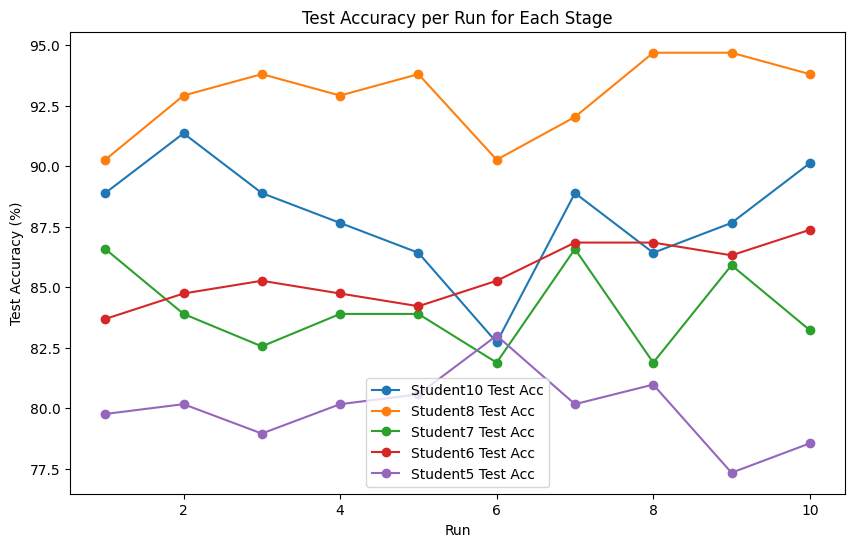

Student10: 87.90%
Student8: 92.92%
Student7: 84.03%
Student6: 85.53%
Student5: 79.96%


In [12]:
import os
import math
import random
import copy
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
# We will filter data per stage later.
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def distillation_loss_sigmoid(student_logits, teacher_logits, student_overlap, teacher_overlap, teacher_acc, T=4.5, clip_min=0.9, clip_max=0.8, k=0.3, c=85):
    """
    Sigmoid-based dynamic clipping version of the distillation loss.
    - T: Fixed temperature.
    - teacher_acc: Teacher's accuracy in [0, 100].
    - The clipping threshold is computed via:
         clip_threshold = clip_min + (clip_max - clip_min) * sigmoid( k*(teacher_acc - c) )
    """
    sigmoid_value = 1.0 / (1.0 + math.exp(-k * (teacher_acc - c)))
    clip_threshold = clip_min + (clip_max - clip_min) * sigmoid_value

    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Partition Evaluation Function
##########################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

##########################################
# Main multi-stage training pipeline
##########################################
# Load raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We'll use the raw_data_all for stage filtering.
# Also store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Initialize teacher variables (for distillation between runs).
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy per stage.
stage_avg_acc = {}

# Stages with minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

# For partition evaluation, we need the overall genus counts.
genera_count = Counter([label for label, _ in raw_data_all])

# Example placeholder for teacher accuracy.
teacher_acc = 90.0  # Adjust or compute this from previous run results.

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Extract vectors and labels.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders (batch size set to 16).
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    
                    if stage_name == "Student6":
                        # Use the sigmoid-based dynamic clipping loss for Student6.
                        loss_kd = distillation_loss_sigmoid(
                            student_logits=outputs,
                            teacher_logits=teacher_outputs,
                            student_overlap=student_overlap,
                            teacher_overlap=teacher_overlap,
                            teacher_acc=teacher_acc,  # teacher's accuracy from previous run
                            T=temperature,
                            clip_min=0.85,
                            clip_max=0.9,
                            k=0.1,
                            c=teacher_acc
                        )
                        loss = alpha * loss_kd + (1 - alpha) * ce_loss
                    else:
                        # Use the original distillation loss for other stages.
                        kd_loss = distillation_loss(
                            outputs, teacher_outputs,
                            student_overlap, teacher_overlap,
                            temperature, clip_threshold=0.9
                        )
                        if stage_name == "Student7":
                            cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                        else:
                            cls_loss = ce_loss
                        loss = alpha * kd_loss + (1 - alpha) * cls_loss
                        
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            
            # Evaluate on test set.
            model.eval()
            correct, total = 0, 0
            epoch_preds = []
            epoch_trues = []
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                    epoch_preds.extend(predicted.cpu().numpy())
                    epoch_trues.extend(labels.cpu().numpy())
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            # Replace best model and its partition predictions if test accuracy improves.
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state and re-evaluate test set using best model.
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        correct, total = 0, 0
        best_preds = []
        best_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                best_preds.extend(predicted.cpu().numpy())
                best_trues.extend(labels.cpu().numpy())
        best_test_acc = 100.0 * correct / total
        print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}%")
        run_accs.append(best_test_acc)
        
        # --- Partition Evaluation using best model predictions --- 
        true_genus = label_encoder.inverse_transform(best_trues)
        pred_genus = label_encoder.inverse_transform(best_preds)
        print(f"\nPartition evaluation for {stage_name} Run {run+1}:")
        evaluate_partitions(true_genus, pred_genus, genera_count)
        
        # Update teacher with the best model from this run.
        teacher_model = model
        teacher_label2idx = student_label2idx
        teacher_acc = best_test_acc  # update teacher accuracy based on this run's best accuracy
        
    avg_stage = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage:.2f}% ***")
    
##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, accs in stage_test_accs.items():
    plt.plot(range(1, num_runs+1), accs, marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# 3nd, logistic distillation, student 6 apply, student 5 clip to 0.8


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 7.3530 | Test Acc: 13.58% | Time: 2.72 sec
Epoch 2/100 | Loss: 2.5132 | Test Acc: 30.86% | Time: 2.55 sec
Epoch 3/100 | Loss: 1.3694 | Test Acc: 65.43% | Time: 2.54 sec
Epoch 4/100 | Loss: 0.7621 | Test Acc: 74.07% | Time: 2.46 sec
Epoch 5/100 | Loss: 0.5066 | Test Acc: 69.14% | Time: 2.45 sec
Epoch 6/100 | Loss: 0.4404 | Test Acc: 81.48% | Time: 2.46 sec
Epoch 7/100 | Loss: 0.3301 | Test Acc: 76.54% | Time: 2.46 sec
Epoch 8/100 | Loss: 0.2233 | Test Acc: 85.19% | Time: 2.46 sec
Epoch 9/100 | Loss: 0.1889 | Test Acc: 82.72% | Time: 2.45 sec
Epoch 10/100 | Loss: 0.2028 | Test Acc: 87.65% | Time: 2.46 sec
Epoch 11/100 | Loss: 0.1552 | Test Acc: 80.25% | Time: 2.45 sec
Epoch 12/100 | Loss: 0.1598 | Test Acc: 91.36% | Time: 2.45 sec
Epoch 13/100 | Loss: 0.1683 | Test Acc: 87.65% | Time: 2.45 sec

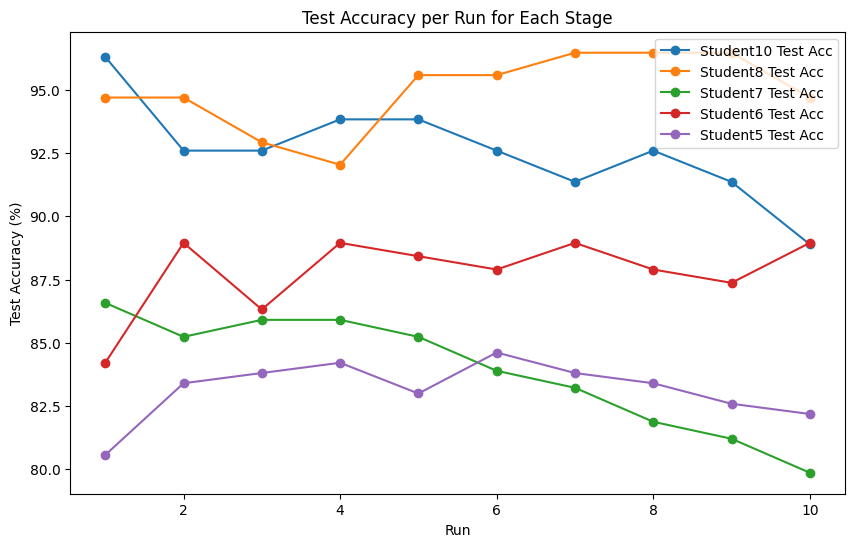

Student10: 92.59%
Student8: 94.96%
Student7: 83.89%
Student6: 87.79%
Student5: 83.16%


In [28]:
import os
import math
import random
import copy
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
# We will filter data per stage later.
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def distillation_loss_sigmoid(student_logits, teacher_logits, student_overlap, teacher_overlap, teacher_acc, T=4.5, clip_min=0.9, clip_max=0.8, k=0.3, c=85):
    """
    Sigmoid-based dynamic clipping version of the distillation loss.
    - T: Fixed temperature.
    - teacher_acc: Teacher's accuracy in [0, 100].
    - The clipping threshold is computed via:
         clip_threshold = clip_min + (clip_max - clip_min) * sigmoid( k*(teacher_acc - c) )
    """
    sigmoid_value = 1.0 / (1.0 + math.exp(-k * (teacher_acc - c)))
    clip_threshold = clip_min + (clip_max - clip_min) * sigmoid_value

    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Partition Evaluation Function
##########################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

##########################################
# Main multi-stage training pipeline
##########################################
# Load raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We'll use the raw_data_all for stage filtering.
# Also store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Initialize teacher variables (for distillation between runs).
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy per stage.
stage_avg_acc = {}

# Stages with minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

# For partition evaluation, we need the overall genus counts.
genera_count = Counter([label for label, _ in raw_data_all])

# Example placeholder for teacher accuracy.
teacher_acc = 90.0  # Adjust or compute this from previous run results.

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Extract vectors and labels.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders (batch size set to 16).
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    
                    if stage_name == "Student6":
                        # Use the sigmoid-based dynamic clipping loss for Student6.
                        loss_kd = distillation_loss_sigmoid(
                            student_logits=outputs,
                            teacher_logits=teacher_outputs,
                            student_overlap=student_overlap,
                            teacher_overlap=teacher_overlap,
                            teacher_acc=teacher_acc,  # teacher's accuracy from previous run
                            T=temperature,
                            clip_min=0.85,
                            clip_max=0.9,
                            k=0.1,
                            c=teacher_acc
                        )
                        loss = alpha * loss_kd + (1 - alpha) * ce_loss
                    elif stage_name == "Student5":
                        # For Student5, use normal distillation loss with clip threshold of 0.8.
                        kd_loss = distillation_loss(
                            outputs, teacher_outputs,
                            student_overlap, teacher_overlap,
                            temperature, clip_threshold=0.8
                        )
                        loss = alpha * kd_loss + (1 - alpha) * ce_loss
                    elif stage_name == "Student7":
                        # For Student7, use focal loss.
                        kd_loss = distillation_loss(
                            outputs, teacher_outputs,
                            student_overlap, teacher_overlap,
                            temperature, clip_threshold=0.9
                        )
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                        loss = alpha * kd_loss + (1 - alpha) * cls_loss
                    else:
                        # For Student8 or other stages.
                        kd_loss = distillation_loss(
                            outputs, teacher_outputs,
                            student_overlap, teacher_overlap,
                            temperature, clip_threshold=0.9
                        )
                        loss = alpha * kd_loss + (1 - alpha) * ce_loss
                        
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            
            # Evaluate on test set.
            model.eval()
            correct, total = 0, 0
            epoch_preds = []
            epoch_trues = []
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                    epoch_preds.extend(predicted.cpu().numpy())
                    epoch_trues.extend(labels.cpu().numpy())
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            # Replace best model and its partition predictions if test accuracy improves.
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state and re-evaluate test set using best model.
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        correct, total = 0, 0
        best_preds = []
        best_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                best_preds.extend(predicted.cpu().numpy())
                best_trues.extend(labels.cpu().numpy())
        best_test_acc = 100.0 * correct / total
        print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}%")
        run_accs.append(best_test_acc)
        
        # --- Partition Evaluation using best model predictions --- 
        true_genus = label_encoder.inverse_transform(best_trues)
        pred_genus = label_encoder.inverse_transform(best_preds)
        print(f"\nPartition evaluation for {stage_name} Run {run+1}:")
        evaluate_partitions(true_genus, pred_genus, genera_count)
        
        # Update teacher with the best model from this run.
        teacher_model = model
        teacher_label2idx = student_label2idx
        teacher_acc = best_test_acc  # update teacher accuracy based on this run's best accuracy
        
    avg_stage = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage:.2f}% ***")
    
##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, accs in stage_test_accs.items():
    plt.plot(range(1, num_runs+1), accs, marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# student7 clip more

# quantization

# base model(no resmapling), fp16

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device).half()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            # Convert data to fp16
            data = data.to(device).half()
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data = data.to(device).half()  # Convert test data to fp16 as well
                labels = labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0123
Run 1, Epoch 2: Accuracy = 0.0123
Run 1, Epoch 3: Accuracy = 0.0123
Run 1, Epoch 4: Accuracy = 0.0123
Run 1, Epoch 5: Accuracy = 0.0123
Run 1, Epoch 6: Accuracy = 0.0123
Run 1, Epoch 7: Accuracy = 0.0123
Run 1, Epoch 8: Accuracy = 0.0123
Run 1, Epoch 9: Accuracy = 0.0123
Run 1, Epoch 10: Accuracy = 0.0123
Run 1, Epoch 11: Accuracy = 0.0123
Run 1, Epoch 12: Accuracy = 0.0123
Run 1, Epoch 13: Accuracy = 0.0123
Run 1, Epoch 14: Accuracy = 0.0123
Run 1, Epoch 15: Accuracy = 0.0123
Run 1, Epoch 16: Accuracy = 0.0123
Run 1, Epoch 17: Accuracy = 0.0123
Run 1, Epoch 18: Accuracy = 0.0123
Run 1, Epoch 19: Accuracy = 0.0123
Run 1, Epoch 20: Accuracy = 0.0123
Run 1, Epoch 21: Accuracy = 0.0123
Run 1, Epoch 22: Accuracy = 0.0123
Run 1, Epoch 23: Accuracy = 0.0123


KeyboardInterrupt: 

# fp16, after trained, best acc turn into fp16 and feed data, tran with fp32, test with fp16, 95.433

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
import copy  # for saving best model state

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The k-mer vector is created as fp32 and label as long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create the model in fp32 for training.
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    best_accuracy = 0.0
    best_model_state = None

    # Training loop in fp32
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data = data.to(device)  # fp32 data for training
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on test set using fp32 during training to track progress
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = copy.deepcopy(model.state_dict())

    # After training for the run, load the best model state
    model.load_state_dict(best_model_state)
    # Convert the best model to fp16 for final evaluation on the test set.
    model.half()  # change model parameters to half precision
    model.eval()

    # For testing in fp16, convert test data to half as well.
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device).half()  # convert test input to fp16
            labels = labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    final_fp16_accuracy = correct / total
    print(f"Run {run+1}: Final FP16 Model Accuracy on Test Set = {final_fp16_accuracy:.4f}")
    
    best_accuracies.append(final_fp16_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0988
Run 1, Epoch 2: Accuracy = 0.3580
Run 1, Epoch 3: Accuracy = 0.6049
Run 1, Epoch 4: Accuracy = 0.7407
Run 1, Epoch 5: Accuracy = 0.8148
Run 1, Epoch 6: Accuracy = 0.8148
Run 1, Epoch 7: Accuracy = 0.8272
Run 1, Epoch 8: Accuracy = 0.8642
Run 1, Epoch 9: Accuracy = 0.7778
Run 1, Epoch 10: Accuracy = 0.7778
Run 1, Epoch 11: Accuracy = 0.8272
Run 1, Epoch 12: Accuracy = 0.8519
Run 1, Epoch 13: Accuracy = 0.8765
Run 1, Epoch 14: Accuracy = 0.7901
Run 1, Epoch 15: Accuracy = 0.8395
Run 1, Epoch 16: Accuracy = 0.7778
Run 1, Epoch 17: Accuracy = 0.8889
Run 1, Epoch 18: Accuracy = 0.8148
Run 1, Epoch 19: Accuracy = 0.8889
Run 1, Epoch 20: Accuracy = 0.7778
Run 1, Epoch 21: Accuracy = 0.7901
Run 1, Epoch 22: Accuracy = 0.8148
Run 1, Epoch 23: Accuracy = 0.8519
Run 1, Epoch 24: Accuracy = 0.9136
Run 1, Epoch 25: Accuracy = 0.9136
Run 1, Epoch 26: Accuracy = 0.8642
Run 1, Epoch 27: Accuracy = 0.8519
Run 1, Epoch 28: Accuracy = 0.8765
Run 1, Epoch 29: Accuracy = 0

# base model(no resmapling), fp16, mix precision, PyTorch AMP Approach (autocast + GradScaler):

Uses floating-point (FP16/FP32) automatically, depending on operation type.
Aims to speed up training and reduce memory usage without significantly altering the model architecture or requiring integer quantization steps.
Easier to integrate into standard PyTorch training loops.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    
    # Initialize GradScaler for mixed precision
    scaler = torch.cuda.amp.GradScaler()

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(data)
                loss = criterion(outputs, labels)
            
            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                # Mixed precision evaluation
                with torch.cuda.amp.autocast():
                    outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1481
Run 1, Epoch 2: Accuracy = 0.3704
Run 1, Epoch 3: Accuracy = 0.5926
Run 1, Epoch 4: Accuracy = 0.7284
Run 1, Epoch 5: Accuracy = 0.8272
Run 1, Epoch 6: Accuracy = 0.8025
Run 1, Epoch 7: Accuracy = 0.8642
Run 1, Epoch 8: Accuracy = 0.8765
Run 1, Epoch 9: Accuracy = 0.9259
Run 1, Epoch 10: Accuracy = 0.8642
Run 1, Epoch 11: Accuracy = 0.8148
Run 1, Epoch 12: Accuracy = 0.8519
Run 1, Epoch 13: Accuracy = 0.8642
Run 1, Epoch 14: Accuracy = 0.7654
Run 1, Epoch 15: Accuracy = 0.7531
Run 1, Epoch 16: Accuracy = 0.8272
Run 1, Epoch 17: Accuracy = 0.8395
Run 1, Epoch 18: Accuracy = 0.8395
Run 1, Epoch 19: Accuracy = 0.7901
Run 1, Epoch 20: Accuracy = 0.8889
Run 1, Epoch 21: Accuracy = 0.8519
Run 1, Epoch 22: Accuracy = 0.8025
Run 1, Epoch 23: Accuracy = 0.8765
Run 1, Epoch 24: Accuracy = 0.8395
Run 1, Epoch 25: Accuracy = 0.8889
Run 1, Epoch 26: Accuracy = 0.8765
Run 1, Epoch 27: Accuracy = 0.8889
Run 1, Epoch 28: Accuracy = 0.9383
Run 1, Epoch 29: Accuracy = 0

# base model(no resmapling), int quantization, mix precision, Figure Approach (Mixed-Precision Quantization):

Uses discrete (integer) representations at different bitwidths for each layer.
Typically a more advanced approach for inference efficiency and model size reduction.
May require specialized hardware support or QAT techniques to maintain accuracy.

Run 1, Epoch 1: Accuracy = 0.1358 (Epoch Time: 1.40 sec)
Run 1, Epoch 2: Accuracy = 0.7654 (Epoch Time: 1.31 sec)
Run 1, Epoch 3: Accuracy = 0.9012 (Epoch Time: 1.30 sec)
Run 1, Epoch 4: Accuracy = 0.9012 (Epoch Time: 1.30 sec)
Run 1, Epoch 5: Accuracy = 0.9630 (Epoch Time: 1.29 sec)
Run 1, Epoch 6: Accuracy = 0.9012 (Epoch Time: 1.29 sec)
Run 1, Epoch 7: Accuracy = 0.9012 (Epoch Time: 1.29 sec)
Run 1, Epoch 8: Accuracy = 0.9012 (Epoch Time: 1.28 sec)
Run 1, Epoch 9: Accuracy = 0.9506 (Epoch Time: 1.30 sec)
Run 1, Epoch 10: Accuracy = 0.9630 (Epoch Time: 1.33 sec)
Run 1, Epoch 11: Accuracy = 0.9259 (Epoch Time: 1.33 sec)
Run 1, Epoch 12: Accuracy = 0.9259 (Epoch Time: 1.29 sec)
Run 1, Epoch 13: Accuracy = 0.8765 (Epoch Time: 1.30 sec)
Run 1, Epoch 14: Accuracy = 0.8765 (Epoch Time: 1.30 sec)
Run 1, Epoch 15: Accuracy = 0.8889 (Epoch Time: 1.31 sec)
Run 1, Epoch 16: Accuracy = 0.9012 (Epoch Time: 1.32 sec)
Run 1, Epoch 17: Accuracy = 0.9136 (Epoch Time: 1.31 sec)
Run 1, Epoch 18: Accura

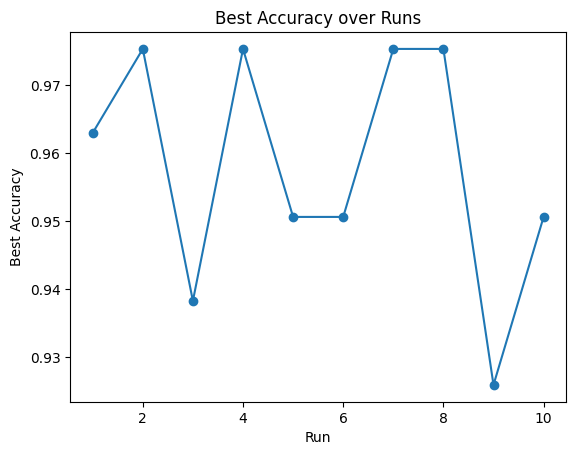

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.quantization as tq
from torch.quantization.fake_quantize import FakeQuantize
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# -------------------------------
# 0. Constants
# -------------------------------
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# -------------------------------
# 1. Custom Observers and QConfig for Arbitrary Bitwidth
# -------------------------------
def make_custom_qconfig(bit_weights, bit_acts):
    """
    Returns a QConfig that uses custom bitwidths for weights and activations.
    bit_weights: integer bits for weights (e.g., 4, 5, 6, 7)
    bit_acts: integer bits for activations (e.g., 4, 5, 6, 7)
    """
    # For weights, use a symmetric range around 0
    weight_quant_min = -(2 ** (bit_weights - 1))
    weight_quant_max = 2 ** (bit_weights - 1) - 1

    # For activations, assume unsigned range [0, 2^bit_acts - 1]
    act_quant_min = 0
    act_quant_max = 2 ** bit_acts - 1

    # Observers
    weight_observer = tq.MinMaxObserver.with_args(
        dtype=torch.qint8,  # We keep qint8 type in PyTorch
        qscheme=torch.per_tensor_symmetric,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_observer = tq.MinMaxObserver.with_args(
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    # FakeQuant modules that use these observers
    weight_fake_quant = FakeQuantize.with_args(
        observer=weight_observer,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_fake_quant = FakeQuantize.with_args(
        observer=act_observer,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    return tq.QConfig(activation=act_fake_quant, weight=weight_fake_quant)

# -------------------------------
# 2. Helper Functions for k-mer Vectorization
# -------------------------------
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# -------------------------------
# 3. Dataset Class
# -------------------------------
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# -------------------------------
# 4. Quantization-Aware CNN Model
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        # Stubs: mark beginning (QuantStub) and end (DeQuantStub) of quant region
        self.quant = tq.QuantStub()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn3   = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear((input_dim // 8) * 128, 1024)
        self.relu4  = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2   = nn.Linear(1024, 256)
        self.relu5  = nn.ReLU()
        self.fc3   = nn.Linear(256, num_classes)

        self.dequant = tq.DeQuantStub()

    def forward(self, x):
        # x is expected shape (batch_size, input_dim)
        x = x.unsqueeze(1)  # -> (batch_size, 1, input_dim)
        x = self.quant(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)

        x = self.dequant(x)
        return x

    def fuse_model(self):
        # Ensure the model is in eval mode before fusion
        self.eval()
        # Fuse conv/bn/relu for each block
        tq.fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                               ['conv2', 'bn2', 'relu2'],
                               ['conv3', 'bn3', 'relu3']], inplace=True)
        # Optionally, you can return to train mode if desired:
        self.train()

# -------------------------------
# 5. Partition Evaluation Function
# -------------------------------
def evaluate_partitions(true_labels, pred_labels, global_counts):
    """
    Partitions the test samples based on global_counts frequency (>=10, ==8, ==7, etc.)
    and computes accuracy for each partition.
    """
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# 6. Data Preprocessing Steps
# -------------------------------
# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    # Write last sequence if any
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# -------------------------------
# 7. Main Experiment Loop (QAT with per-layer bitwidths)
# -------------------------------
best_accuracies = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for run in range(num_runs):
    run_start_time = time.time()

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    # Create CNN model
    model = CNNModel(input_dim=len(train_vectors[0]), num_classes=len(label_encoder.classes_))
    # Ensure model is in eval mode before fusion
    model.eval()
    model.fuse_model()  # Fuse modules (conv, bn, relu)
    model.train()  # Return to train mode if desired

    # Assign custom QConfigs to each layer
    model.conv1.qconfig = make_custom_qconfig(8, 8)  # Quantize conv1 with 8-bit weight/activation
    model.conv2.qconfig = None                       
    model.conv3.qconfig = make_custom_qconfig(8, 8)  # Quantize conv3 with 8-bit weight/activation

    # Optionally assign QConfig for linear layers:
    # model.fc1.qconfig = make_custom_qconfig(8, 8)
    # model.fc2.qconfig = make_custom_qconfig(8, 8)
    # model.fc3.qconfig = make_custom_qconfig(8, 8)

    # Prepare QAT
    tq.prepare_qat(model, inplace=True)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        for data_batch, labels_batch in train_loader:
            data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(data_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data_batch, labels_batch in test_loader:
                data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
                outputs = model(data_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels_batch).sum().item()
                total += labels_batch.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels_batch.cpu().numpy())

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]

    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    # Convert to a quantized model (still uses int8 under the hood)
    model.eval()
    quantized_model = tq.convert(model.cpu(), inplace=False)

    # Partition Evaluation
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# Optional: Plot the best accuracy from each run
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# change more, layer 2 quantize to int8 too

Run 1, Epoch 1: Accuracy = 0.1358 (Epoch Time: 1.57 sec)
Run 1, Epoch 2: Accuracy = 0.6914 (Epoch Time: 1.36 sec)
Run 1, Epoch 3: Accuracy = 0.8889 (Epoch Time: 1.41 sec)
Run 1, Epoch 4: Accuracy = 0.8765 (Epoch Time: 1.39 sec)
Run 1, Epoch 5: Accuracy = 0.9012 (Epoch Time: 1.38 sec)
Run 1, Epoch 6: Accuracy = 0.8889 (Epoch Time: 1.35 sec)
Run 1, Epoch 7: Accuracy = 0.8765 (Epoch Time: 1.31 sec)
Run 1, Epoch 8: Accuracy = 0.9259 (Epoch Time: 1.40 sec)
Run 1, Epoch 9: Accuracy = 0.9259 (Epoch Time: 1.38 sec)
Run 1, Epoch 10: Accuracy = 0.9259 (Epoch Time: 1.39 sec)
Run 1, Epoch 11: Accuracy = 0.9383 (Epoch Time: 1.43 sec)
Run 1, Epoch 12: Accuracy = 0.8765 (Epoch Time: 1.42 sec)
Run 1, Epoch 13: Accuracy = 0.9259 (Epoch Time: 1.37 sec)
Run 1, Epoch 14: Accuracy = 0.9259 (Epoch Time: 1.37 sec)
Run 1, Epoch 15: Accuracy = 0.9012 (Epoch Time: 1.40 sec)
Run 1, Epoch 16: Accuracy = 0.9136 (Epoch Time: 1.40 sec)
Run 1, Epoch 17: Accuracy = 0.9012 (Epoch Time: 1.37 sec)
Run 1, Epoch 18: Accura

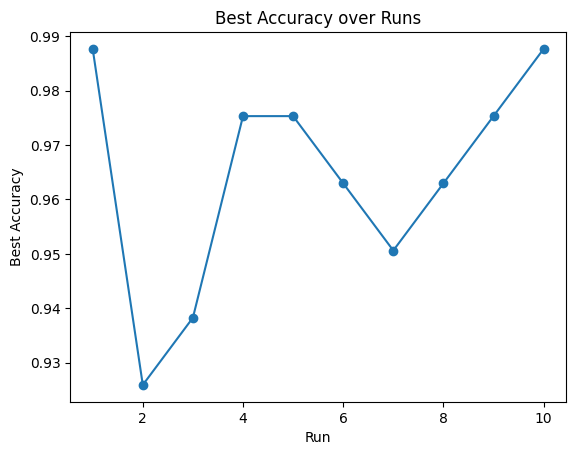

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.quantization as tq
from torch.quantization.fake_quantize import FakeQuantize
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# -------------------------------
# 0. Constants
# -------------------------------
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# -------------------------------
# 1. Custom Observers and QConfig for Arbitrary Bitwidth
# -------------------------------
def make_custom_qconfig(bit_weights, bit_acts):
    """
    Returns a QConfig that uses custom bitwidths for weights and activations.
    bit_weights: integer bits for weights (e.g., 4, 5, 6, 7)
    bit_acts: integer bits for activations (e.g., 4, 5, 6, 7)
    """
    # For weights, use a symmetric range around 0
    weight_quant_min = -(2 ** (bit_weights - 1))
    weight_quant_max = 2 ** (bit_weights - 1) - 1

    # For activations, assume unsigned range [0, 2^bit_acts - 1]
    act_quant_min = 0
    act_quant_max = 2 ** bit_acts - 1

    # Observers
    weight_observer = tq.MinMaxObserver.with_args(
        dtype=torch.qint8,  # We keep qint8 type in PyTorch
        qscheme=torch.per_tensor_symmetric,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_observer = tq.MinMaxObserver.with_args(
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    # FakeQuant modules that use these observers
    weight_fake_quant = FakeQuantize.with_args(
        observer=weight_observer,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_fake_quant = FakeQuantize.with_args(
        observer=act_observer,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    return tq.QConfig(activation=act_fake_quant, weight=weight_fake_quant)

# -------------------------------
# 2. Helper Functions for k-mer Vectorization
# -------------------------------
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# -------------------------------
# 3. Dataset Class
# -------------------------------
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# -------------------------------
# 4. Quantization-Aware CNN Model
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        # Stubs: mark beginning (QuantStub) and end (DeQuantStub) of quant region
        self.quant = tq.QuantStub()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn3   = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear((input_dim // 8) * 128, 1024)
        self.relu4  = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2   = nn.Linear(1024, 256)
        self.relu5  = nn.ReLU()
        self.fc3   = nn.Linear(256, num_classes)

        self.dequant = tq.DeQuantStub()

    def forward(self, x):
        # x is expected shape (batch_size, input_dim)
        x = x.unsqueeze(1)  # -> (batch_size, 1, input_dim)
        x = self.quant(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)

        x = self.dequant(x)
        return x

    def fuse_model(self):
        # Ensure the model is in eval mode before fusion
        self.eval()
        # Fuse conv/bn/relu for each block
        tq.fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                               ['conv2', 'bn2', 'relu2'],
                               ['conv3', 'bn3', 'relu3']], inplace=True)
        # Optionally, you can return to train mode if desired:
        self.train()

# -------------------------------
# 5. Partition Evaluation Function
# -------------------------------
def evaluate_partitions(true_labels, pred_labels, global_counts):
    """
    Partitions the test samples based on global_counts frequency (>=10, ==8, ==7, etc.)
    and computes accuracy for each partition.
    """
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# 6. Data Preprocessing Steps
# -------------------------------
# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    # Write last sequence if any
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# -------------------------------
# 7. Main Experiment Loop (QAT with per-layer bitwidths)
# -------------------------------
best_accuracies = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for run in range(num_runs):
    run_start_time = time.time()

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    # Create CNN model
    model = CNNModel(input_dim=len(train_vectors[0]), num_classes=len(label_encoder.classes_))
    # Ensure model is in eval mode before fusion
    model.eval()
    model.fuse_model()  # Fuse modules (conv, bn, relu)
    model.train()  # Return to train mode if desired

    # Assign custom QConfigs to each layer
    model.conv1.qconfig = make_custom_qconfig(8, 8)  # Quantize conv1 with 8-bit weight/activation
    model.conv2.qconfig = make_custom_qconfig(8, 8)                      
    model.conv3.qconfig = make_custom_qconfig(8, 8)  # Quantize conv3 with 8-bit weight/activation

    # Optionally assign QConfig for linear layers:
    # model.fc1.qconfig = make_custom_qconfig(8, 8)
    # model.fc2.qconfig = make_custom_qconfig(8, 8)
    # model.fc3.qconfig = make_custom_qconfig(8, 8)

    # Prepare QAT
    tq.prepare_qat(model, inplace=True)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        for data_batch, labels_batch in train_loader:
            data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(data_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data_batch, labels_batch in test_loader:
                data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
                outputs = model(data_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels_batch).sum().item()
                total += labels_batch.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels_batch.cpu().numpy())

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]

    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    # Convert to a quantized model (still uses int8 under the hood)
    model.eval()
    quantized_model = tq.convert(model.cpu(), inplace=False)

    # Partition Evaluation
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# Optional: Plot the best accuracy from each run
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# change more

Run 1, Epoch 1: Accuracy = 0.4074 (Epoch Time: 1.40 sec)
Run 1, Epoch 2: Accuracy = 0.6914 (Epoch Time: 1.22 sec)
Run 1, Epoch 3: Accuracy = 0.7654 (Epoch Time: 1.23 sec)
Run 1, Epoch 4: Accuracy = 0.7901 (Epoch Time: 1.21 sec)
Run 1, Epoch 5: Accuracy = 0.7407 (Epoch Time: 1.21 sec)
Run 1, Epoch 6: Accuracy = 0.8272 (Epoch Time: 1.21 sec)
Run 1, Epoch 7: Accuracy = 0.7654 (Epoch Time: 1.20 sec)
Run 1, Epoch 8: Accuracy = 0.8025 (Epoch Time: 1.19 sec)
Run 1, Epoch 9: Accuracy = 0.8272 (Epoch Time: 1.19 sec)
Run 1, Epoch 10: Accuracy = 0.8148 (Epoch Time: 1.18 sec)
Run 1, Epoch 11: Accuracy = 0.8148 (Epoch Time: 1.19 sec)
Run 1, Epoch 12: Accuracy = 0.8148 (Epoch Time: 1.20 sec)
Run 1, Epoch 13: Accuracy = 0.8272 (Epoch Time: 1.20 sec)
Run 1, Epoch 14: Accuracy = 0.8148 (Epoch Time: 1.19 sec)
Run 1, Epoch 15: Accuracy = 0.8272 (Epoch Time: 1.19 sec)
Run 1, Epoch 16: Accuracy = 0.8272 (Epoch Time: 1.19 sec)
Run 1, Epoch 17: Accuracy = 0.8272 (Epoch Time: 1.18 sec)
Run 1, Epoch 18: Accura

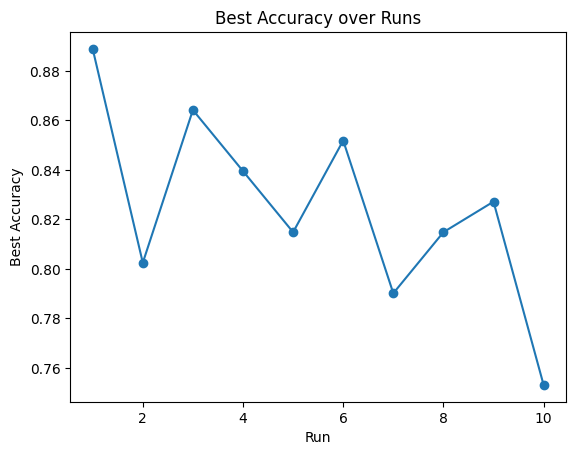

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.quantization as tq
from torch.quantization.fake_quantize import FakeQuantize
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy

# -------------------------------
# 0. Constants
# -------------------------------
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# -------------------------------
# 1. Custom Observers and QConfig for Arbitrary Bitwidth
# -------------------------------
def make_custom_qconfig(bit_weights, bit_acts):
    """
    Returns a QConfig that uses custom bitwidths for weights and activations.
    bit_weights: integer bits for weights (e.g., 4, 5, 6, 7)
    bit_acts: integer bits for activations (e.g., 4, 5, 6, 7)
    """
    # For weights, use a symmetric range around 0
    weight_quant_min = -(2 ** (bit_weights - 1))
    weight_quant_max = 2 ** (bit_weights - 1) - 1

    # For activations, assume unsigned range [0, 2^bit_acts - 1]
    act_quant_min = 0
    act_quant_max = 2 ** bit_acts - 1

    # Observers
    weight_observer = tq.MinMaxObserver.with_args(
        dtype=torch.qint8,  # We keep qint8 type in PyTorch
        qscheme=torch.per_tensor_symmetric,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_observer = tq.MinMaxObserver.with_args(
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    # FakeQuant modules that use these observers
    weight_fake_quant = FakeQuantize.with_args(
        observer=weight_observer,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_fake_quant = FakeQuantize.with_args(
        observer=act_observer,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    return tq.QConfig(activation=act_fake_quant, weight=weight_fake_quant)

# -------------------------------
# 2. Helper Functions for k-mer Vectorization
# -------------------------------
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# -------------------------------
# 3. Dataset Class
# -------------------------------
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# -------------------------------
# 4. Quantization-Aware CNN Model
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        # Stubs: mark beginning (QuantStub) and end (DeQuantStub) of quant region
        self.quant = tq.QuantStub()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn3   = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear((input_dim // 8) * 128, 1024)
        self.relu4  = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2   = nn.Linear(1024, 256)
        self.relu5  = nn.ReLU()
        self.fc3   = nn.Linear(256, num_classes)

        self.dequant = tq.DeQuantStub()

    def forward(self, x):
        # x is expected shape (batch_size, input_dim)
        x = x.unsqueeze(1)  # -> (batch_size, 1, input_dim)
        x = self.quant(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)

        x = self.dequant(x)
        return x

    def fuse_model(self):
        # Ensure the model is in eval mode before fusion
        self.eval()
        # Fuse conv/bn/relu for each block
        tq.fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                               ['conv2', 'bn2', 'relu2'],
                               ['conv3', 'bn3', 'relu3']], inplace=True)
        # Optionally, you can return to train mode if desired:
        self.train()

# -------------------------------
# 5. Partition Evaluation Function
# -------------------------------
def evaluate_partitions(true_labels, pred_labels, global_counts):
    """
    Partitions the test samples based on global_counts frequency (>=10, ==8, ==7, etc.)
    and computes accuracy for each partition.
    """
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# 6. Data Preprocessing Steps
# -------------------------------
# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    # Write last sequence if any
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# -------------------------------
# 7. Main Experiment Loop (QAT with per-layer bitwidths)
# -------------------------------
best_accuracies = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for run in range(num_runs):
    run_start_time = time.time()

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    # Create CNN model
    model = CNNModel(input_dim=len(train_vectors[0]), num_classes=len(label_encoder.classes_))
    # Ensure model is in eval mode before fusion
    model.eval()
    model.fuse_model()  # Fuse modules (conv, bn, relu)
    model.train()  


    # model.conv1.qconfig = make_custom_qconfig(4, 5)  # Quantize conv1 with 8-bit weight/activation
    # model.conv2.qconfig = make_custom_qconfig(6, 7)  # Quantize conv3 with 8-bit weight/activation                    
    # model.conv3.qconfig = make_custom_qconfig(5, 4)  # Quantize conv3 with 8-bit weight/activation

    #avg_acc = 95

    # model.conv1.qconfig = make_custom_qconfig(3, 4)  
    # model.conv2.qconfig = make_custom_qconfig(5, 6)                      
    # model.conv3.qconfig = make_custom_qconfig(4, 3)  

    #avg_acc = 93.95

    model.conv1.qconfig = make_custom_qconfig(2, 3)  
    model.conv2.qconfig = make_custom_qconfig(4, 5)                      
    model.conv3.qconfig = make_custom_qconfig(3, 2)  

    #avg_acc = 82.47
    

    tq.prepare_qat(model, inplace=True)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        for data_batch, labels_batch in train_loader:
            data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(data_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data_batch, labels_batch in test_loader:
                data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
                outputs = model(data_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels_batch).sum().item()
                total += labels_batch.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels_batch.cpu().numpy())

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        # Save best state
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]

    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    # Convert to a quantized model (still uses int8 under the hood)
    model.eval()
    quantized_model = tq.convert(model.cpu(), inplace=False)

    # Partition Evaluation
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

# Final overall average accuracy
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# Optional: Plot the best accuracy from each run
plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# int bit quantization with RL

RL Run 1, Episode 1: Reward = -0.5936, Accuracy = 0.0864
RL Run 1, Episode 2: Reward = -0.3096, Accuracy = 0.3704
RL Run 1, Episode 3: Reward = 0.1360, Accuracy = 0.7160
RL Run 1, Episode 4: Reward = 0.0479, Accuracy = 0.5679
RL Run 1, Episode 5: Reward = 0.1343, Accuracy = 0.6543
Best RL configuration for Run 1: [(6, 6), (7, 3), (4, 3)] with reward 0.1360
Run 1, Epoch 1: Accuracy = 0.1481 (Time: 1.41 sec)
Run 1, Epoch 2: Accuracy = 0.6914 (Time: 1.37 sec)
Run 1, Epoch 3: Accuracy = 0.8025 (Time: 1.41 sec)
Run 1, Epoch 4: Accuracy = 0.8642 (Time: 1.37 sec)
Run 1, Epoch 5: Accuracy = 0.8642 (Time: 1.37 sec)
Run 1, Epoch 6: Accuracy = 0.8519 (Time: 1.42 sec)
Run 1, Epoch 7: Accuracy = 0.8519 (Time: 1.45 sec)
Run 1, Epoch 8: Accuracy = 0.8642 (Time: 1.36 sec)
Run 1, Epoch 9: Accuracy = 0.8765 (Time: 1.43 sec)
Run 1, Epoch 10: Accuracy = 0.8642 (Time: 1.36 sec)
Run 1, Epoch 11: Accuracy = 0.8765 (Time: 1.40 sec)
Run 1, Epoch 12: Accuracy = 0.8765 (Time: 1.42 sec)
Run 1, Epoch 13: Accuracy 

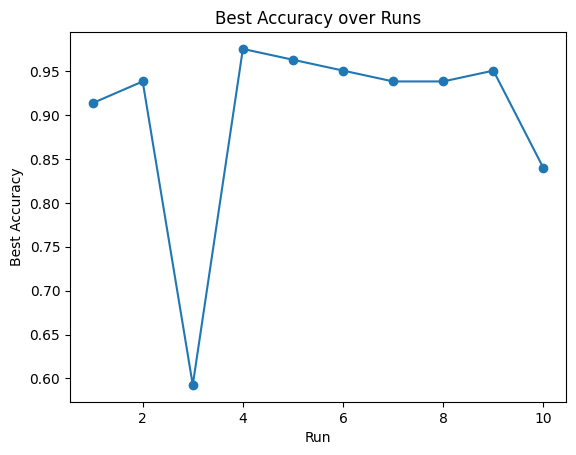

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.quantization as tq
from torch.quantization.fake_quantize import FakeQuantize
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict, Counter
import time
import copy
import numpy as np

# -------------------------------
# 0. Constants
# -------------------------------
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# RL constants
MIN_BITS = 2
MAX_BITS = 8
ALPHA_PENALTY = 0.02  # penalty coefficient for total bit usage in RL reward

# Set device to CUDA (all tensors will be on cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------
# 1. Custom Observers and QConfig for Arbitrary Bitwidth
# -------------------------------
def make_custom_qconfig(bit_weights, bit_acts):
    """
    Returns a QConfig that uses custom bitwidths for weights and activations.
    """
    # For weights, use a symmetric range around 0
    weight_quant_min = -(2 ** (bit_weights - 1))
    weight_quant_max = 2 ** (bit_weights - 1) - 1

    # For activations, assume unsigned range [0, 2^bit_acts - 1]
    act_quant_min = 0
    act_quant_max = 2 ** bit_acts - 1

    weight_observer = tq.MinMaxObserver.with_args(
        dtype=torch.qint8,
        qscheme=torch.per_tensor_symmetric,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_observer = tq.MinMaxObserver.with_args(
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    weight_fake_quant = FakeQuantize.with_args(
        observer=weight_observer,
        quant_min=weight_quant_min,
        quant_max=weight_quant_max
    )
    act_fake_quant = FakeQuantize.with_args(
        observer=act_observer,
        quant_min=act_quant_min,
        quant_max=act_quant_max
    )

    return tq.QConfig(activation=act_fake_quant, weight=weight_fake_quant)

# -------------------------------
# 2. Helper Functions for k-mer Vectorization
# -------------------------------
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

# -------------------------------
# 3. Dataset Class
# -------------------------------
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

# -------------------------------
# 4. Quantization-Aware CNN Model
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.quant = tq.QuantStub()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn3   = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear((input_dim // 8) * 128, 1024)
        self.relu4  = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2   = nn.Linear(1024, 256)
        self.relu5  = nn.ReLU()
        self.fc3   = nn.Linear(256, num_classes)

        self.dequant = tq.DeQuantStub()

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        x = self.quant(x)
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        x = self.dequant(x)
        return x

    def fuse_model(self):
        self.eval()
        tq.fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                               ['conv2', 'bn2', 'relu2'],
                               ['conv3', 'bn3', 'relu3']], inplace=True)
        self.train()

# -------------------------------
# 5. Partition Evaluation Function
# -------------------------------
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

# -------------------------------
# 6. Data Preprocessing Steps
# -------------------------------
# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# -------------------------------
# 7. RL Environment and Agent for Bitwidth Selection
# -------------------------------
class RLQuantEnv:
    """
    This Gym-like environment lets an agent choose (bit_weights, bit_acts) for each
    of the three conv layers ('conv1','conv2','conv3'). After all layers are set,
    a short QAT is performed and validation accuracy (minus a penalty) is returned as the reward.
    """
    def __init__(self, model, train_fn, eval_fn, layer_names=['conv1', 'conv2', 'conv3']):
        self.model = model
        self.train_fn = train_fn
        self.eval_fn = eval_fn
        self.layer_names = layer_names
        self.action_space_size = (MAX_BITS - MIN_BITS + 1) ** 2  # 49 discrete choices
        self.reset()
    
    def reset(self):
        self.current_layer_idx = 0
        self.chosen_bits = []
        # Clear any previous qconfig assignments on the conv layers
        for ln in self.layer_names:
            getattr(self.model, ln).qconfig = None
        return np.array([self.current_layer_idx], dtype=np.float32)
    
    def step(self, action_idx):
        # Map action_idx to (bit_weights, bit_acts)
        bit_w, bit_a = self._action_idx_to_bits(action_idx)
        layer_name = self.layer_names[self.current_layer_idx]
        # Set qconfig for current layer
        qconf = make_custom_qconfig(bit_w, bit_a)
        getattr(self.model, layer_name).qconfig = qconf
        self.chosen_bits.append((bit_w, bit_a))
        self.current_layer_idx += 1
        done = (self.current_layer_idx >= len(self.layer_names))
        if not done:
            return np.array([self.current_layer_idx], dtype=np.float32), 0.0, False, {}
        else:
            # Ensure model is in training mode before QAT preparation
            self.model.train()
            tq.prepare_qat(self.model, inplace=True)
            # Short training (e.g., one epoch over train_loader)
            self.train_fn(self.model)
            # Evaluate on validation data
            accuracy = self.eval_fn(self.model)
            total_bits = sum(bw + ba for (bw, ba) in self.chosen_bits)
            reward = accuracy - ALPHA_PENALTY * total_bits
            return np.array([self.current_layer_idx], dtype=np.float32), reward, True, {"accuracy": accuracy}
    
    def _action_idx_to_bits(self, idx):
        bit_values = list(range(MIN_BITS, MAX_BITS + 1))
        combos = [(bw, ba) for bw in bit_values for ba in bit_values]
        return combos[idx]

class SimpleActorCritic(nn.Module):
    """
    A simple actor-critic network for discrete action selection.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def act(self, state):
        # Move state tensor to CUDA
        device_local = next(self.actor.parameters()).device
        state_t = torch.FloatTensor(state).to(device_local)
        logits = self.actor(state_t)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample().item()
        return action, dist
    def value(self, state):
        device_local = next(self.critic.parameters()).device
        state_t = torch.FloatTensor(state).to(device_local)
        return self.critic(state_t)

def short_train_fn(model, train_loader, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)
    for data_batch, labels_batch in train_loader:
        data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(data_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

def short_eval_fn(model, test_loader, device):
    model.eval()
    model.to(device)
    correct, total = 0, 0
    with torch.no_grad():
        for data_batch, labels_batch in test_loader:
            data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
            outputs = model(data_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels_batch).sum().item()
            total += labels_batch.size(0)
    return correct / total if total > 0 else 0.0

# -------------------------------
# 8. Main Experiment Loop (with RL bitwidth selection)
# -------------------------------
best_accuracies = []

# For RL short training, we use a few episodes (e.g., 5 episodes)
RL_NUM_EPISODES = 5

for run in range(num_runs):
    run_start_time = time.time()

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([s for s in samples if s != test_sample])

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    # Create a new CNN model per run
    model = CNNModel(input_dim=len(train_vectors[0]), num_classes=len(label_encoder.classes_))
    model.eval()
    model.fuse_model()
    model.train()

    # --- RL Bitwidth Selection Phase ---
    # Copy model for RL; move to CUDA
    model_rl = copy.deepcopy(model).to(device)
    rl_env = RLQuantEnv(model_rl,
                        train_fn=lambda m: short_train_fn(m, train_loader, device),
                        eval_fn=lambda m: short_eval_fn(m, test_loader, device),
                        layer_names=['conv1', 'conv2', 'conv3'])
    state_dim = 1
    action_dim = (MAX_BITS - MIN_BITS + 1) ** 2
    agent = SimpleActorCritic(state_dim, action_dim).to(device)
    actor_optimizer = optim.Adam(agent.actor.parameters(), lr=1e-3)
    critic_optimizer = optim.Adam(agent.critic.parameters(), lr=1e-3)
    gamma = 0.99

    best_rl_reward = -float('inf')
    best_config = None

    for ep in range(RL_NUM_EPISODES):
        state = rl_env.reset()
        done = False
        trajectory = []
        while not done:
            action_idx, dist = agent.act(state)
            next_state, reward, done, info = rl_env.step(action_idx)
            trajectory.append((state, action_idx, dist, reward))
            state = next_state
        # Compute returns
        returns = []
        R = 0
        for (_, _, _, r) in reversed(trajectory):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns).to(device)
        actor_loss = 0
        critic_loss = 0
        for i, (st, a_idx, dist, r) in enumerate(trajectory):
            st_t = torch.FloatTensor(st).to(device)
            value_st = agent.value(st)
            advantage = returns[i] - value_st.item()
            logits = agent.actor(st_t)
            dist_new = torch.distributions.Categorical(logits=logits)
            log_prob = dist_new.log_prob(torch.tensor(a_idx, device=device))
            actor_loss += -log_prob * advantage
            critic_loss += F.mse_loss(value_st, returns[i].unsqueeze(0))
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        final_reward = trajectory[-1][3]
        if final_reward > best_rl_reward:
            best_rl_reward = final_reward
            best_config = rl_env.chosen_bits.copy()
        print(f"RL Run {run+1}, Episode {ep+1}: Reward = {final_reward:.4f}, Accuracy = {info.get('accuracy', 0):.4f}")

    print(f"Best RL configuration for Run {run+1}: {best_config} with reward {best_rl_reward:.4f}")

    # --- Full Training with RL-selected Quantization ---
    if best_config is not None and len(best_config) == 3:
        model.conv1.qconfig = make_custom_qconfig(*best_config[0])
        model.conv2.qconfig = make_custom_qconfig(*best_config[1])
        model.conv3.qconfig = make_custom_qconfig(*best_config[2])
    else:
        model.conv1.qconfig = make_custom_qconfig(2, 3)
        model.conv2.qconfig = make_custom_qconfig(4, 5)
        model.conv3.qconfig = make_custom_qconfig(3, 2)
    
    tq.prepare_qat(model, inplace=True)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    best_state = None
    best_preds = []
    best_trues = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        for data_batch, labels_batch in train_loader:
            data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(data_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time

        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data_batch, labels_batch in test_loader:
                data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
                outputs = model(data_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels_batch).sum().item()
                total += labels_batch.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels_batch.cpu().numpy())
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Time: {epoch_duration:.2f} sec)")
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_state = copy.deepcopy(model.state_dict())
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]
    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")
    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    quantized_model = tq.convert(model.cpu(), inplace=False)
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_genus, pred_genus, genera_count)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

plt.figure()
plt.plot(range(1, num_runs+1), best_accuracies, marker='o')
plt.xlabel('Run')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy over Runs')
plt.show()


# another RL

# base model(no resmapling), fp16, mix precision, Figure Approach (Mixed-Precision Quantization), with design automation, automactic choose 

In [ ]:
pip install stable-baselines3 gym

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym import spaces

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

# -----------------------------------------------------------------------------
# 1. Fake Quantization and QuantConv1d
# -----------------------------------------------------------------------------
def fake_quantize(x, num_bits=8):
    """
    Naive fake-quantization of tensor x to num_bits.
    Uses symmetric quantization (no zero-point) around zero.
    """
    qmin = -(2**(num_bits - 1))
    qmax =  2**(num_bits - 1) - 1

    max_val = x.abs().max()
    if max_val < 1e-8:
        return x  # If near zero, do nothing

    scale = max_val / qmax
    x_int = torch.round(x / scale).clamp(qmin, qmax)
    return x_int * scale

class QuantConv1d(nn.Conv1d):
    """
    1D convolution layer that applies fake quantization
    for weights and activations with specified bitwidths.
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, bias=True,
                 weight_bits=8, act_bits=8):
        super().__init__(in_channels, out_channels, kernel_size,
                         stride, padding, dilation, groups, bias)
        self.weight_bits = weight_bits
        self.act_bits = act_bits

    def forward(self, x):
        # Fake-quantize weights & bias
        q_weight = fake_quantize(self.weight, self.weight_bits)
        q_bias = None
        if self.bias is not None:
            q_bias = fake_quantize(self.bias, self.weight_bits)

        # Convolution with quantized weights
        out = F.conv1d(x, q_weight, q_bias, self.stride,
                       self.padding, self.dilation, self.groups)

        # Fake-quantize the output activations
        out = fake_quantize(out, self.act_bits)
        return out

# -----------------------------------------------------------------------------
# 2. Configurable CNN Model with Per-Layer Bitwidths
# -----------------------------------------------------------------------------
class ConfigurableQuantCNN(nn.Module):
    """
    Example CNN with 3 quantized conv layers, each having (weight_bits, act_bits)
    as specified by layer_configs = [(wbits1, abits1), (wbits2, abits2), (wbits3, abits3)].
    """
    def __init__(self, input_dim, num_classes, layer_configs):
        super().__init__()
        # For demonstration, we assume 3 layers:
        # layer_configs = [(wbits1, abits1), (wbits2, abits2), (wbits3, abits3)]
        (wbits1, abits1) = layer_configs[0]
        (wbits2, abits2) = layer_configs[1]
        (wbits3, abits3) = layer_configs[2]

        self.conv1 = QuantConv1d(1, 32, kernel_size=7, padding='same',
                                 weight_bits=wbits1, act_bits=abits1)
        self.bn1   = nn.BatchNorm1d(32)

        self.conv2 = QuantConv1d(32, 64, kernel_size=7, padding='same',
                                 weight_bits=wbits2, act_bits=abits2)
        self.bn2   = nn.BatchNorm1d(64)

        self.conv3 = QuantConv1d(64, 128, kernel_size=7, padding='same',
                                 weight_bits=wbits3, act_bits=abits3)
        self.bn3   = nn.BatchNorm1d(128)

        self.pool  = nn.MaxPool1d(2)
        # After 3 pools, input_dim // 8 (assuming input_dim is divisible by 8)
        self.fc1   = nn.Linear((input_dim // 8) * 128, 1024)
        self.fc2   = nn.Linear(1024, 256)
        self.fc3   = nn.Linear(256, num_classes)

    def forward(self, x):
        # Expect x shape: (batch_size, input_dim)
        x = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, 0.2, training=self.training)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -----------------------------------------------------------------------------
# 3. Gym Environment: Assign Bitwidths, Then Evaluate
# -----------------------------------------------------------------------------
class QuantizationEnv(gym.Env):
    """
    Environment where an agent picks (weight_bits, act_bits) for each of 3 conv layers.
    Once all layers are assigned, we build the model, do a short training/eval, and return a reward.
    """
    def __init__(self, input_dim, num_classes,
                 train_data, test_data,
                 device='cpu',
                 min_bits=2, max_bits=16):
        super().__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes
        self.train_data = train_data  # (X_train, y_train)
        self.test_data  = test_data   # (X_test,  y_test)
        self.device = device

        # We fix 3 layers for demonstration
        self.n_layers = 3
        self.current_layer = 0
        self.done = False

        # Action space: 2 continuous values [wbits, abits], each in [min_bits, max_bits]
        self.action_space = spaces.Box(
            low=np.array([min_bits, min_bits], dtype=np.float32),
            high=np.array([max_bits, max_bits], dtype=np.float32),
            shape=(2,),
            dtype=np.float32
        )

        # Observation space: for simplicity, just the index of the current layer
        # We'll represent it as a discrete space of size n_layers+1
        self.observation_space = spaces.Discrete(self.n_layers + 1)

        # Layer configs storage
        self.layer_configs = [(8, 8)] * self.n_layers  # default (8,8) for each layer

    def reset(self):
        self.current_layer = 0
        self.layer_configs = [(8, 8)] * self.n_layers
        self.done = False
        return self._get_obs()

    def _get_obs(self):
        # Return current layer index
        return self.current_layer

    def step(self, action):
        if self.done:
            return self._get_obs(), 0.0, True, {}

        wbits_float, abits_float = action
        # Convert to valid integer bitwidths
        wbits = int(np.clip(round(wbits_float), 2, 16))
        abits = int(np.clip(round(abits_float), 2, 16))

        # Assign to current layer
        self.layer_configs[self.current_layer] = (wbits, abits)
        self.current_layer += 1

        # If we've assigned all layers, evaluate
        if self.current_layer >= self.n_layers:
            reward = self._evaluate_model()
            self.done = True
            return self._get_obs(), reward, True, {}
        else:
            return self._get_obs(), 0.0, False, {}

    def _evaluate_model(self):
        """
        Build a ConfigurableQuantCNN with the chosen bitwidths,
        do a small training run, evaluate accuracy, and compute a reward
        that penalizes large bitwidth usage.
        """
        model = ConfigurableQuantCNN(
            self.input_dim, self.num_classes, self.layer_configs
        ).to(self.device)

        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        X_train, y_train = self.train_data
        X_test, y_test   = self.test_data

        # Tiny training loop (2 epochs for demonstration)
        model.train()
        for _ in range(2):
            optimizer.zero_grad()
            outputs = model(X_train.to(self.device))
            loss = criterion(outputs, y_train.to(self.device))
            loss.backward()
            optimizer.step()

        # Evaluate accuracy
        model.eval()
        with torch.no_grad():
            preds = model(X_test.to(self.device)).argmax(dim=1)
            accuracy = (preds == y_test.to(self.device)).float().mean().item()

        # Compute penalty for total bit usage
        total_bits = 0
        for (wb, ab) in self.layer_configs:
            total_bits += (wb + ab)
        penalty = 0.001 * total_bits

        reward = accuracy - penalty
        return reward

    def render(self, mode='human'):
        print(f"Layer {self.current_layer}, configs: {self.layer_configs}")

    def close(self):
        pass

# -----------------------------------------------------------------------------
# 4. Example: Training a DDPG Agent
# -----------------------------------------------------------------------------
def prepare_dummy_data():
    """
    Returns dummy data for demonstration: (X_train, y_train), (X_test, y_test)
    Each is a Tensor. Suppose input_dim=128, num_classes=10.
    """
    X_train = torch.randn(64, 128)  # 64 samples, each with "128 features"
    y_train = torch.randint(0, 10, (64,))
    X_test  = torch.randn(32, 128)  # 32 samples for test
    y_test  = torch.randint(0, 10, (32,))
    return (X_train, y_train), (X_test, y_test)

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare some dummy data
    (X_train, y_train), (X_test, y_test) = prepare_dummy_data()
    input_dim = X_train.shape[1]
    num_classes = 10

    # Create the environment
    env = QuantizationEnv(
        input_dim=input_dim,
        num_classes=num_classes,
        train_data=(X_train, y_train),
        test_data=(X_test,  y_test),
        device=device,
        min_bits=2,
        max_bits=16
    )

    # Wrap environment in a vectorized env for stable-baselines3
    vec_env = DummyVecEnv([lambda: env])

    # Setup DDPG with some action noise for exploration
    n_actions = env.action_space.shape[0]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.5 * np.ones(n_actions))
    model = DDPG("MlpPolicy", vec_env, action_noise=action_noise, verbose=1)

    # Train the agent for a small number of steps (just demonstration)
    # Each "episode" is 3 steps (for 3 layers). So 60 steps ~ 20 episodes.
    model.learn(total_timesteps=60)

    # Evaluate the trained agent
    obs = vec_env.reset()
    for _ in range(env.n_layers):
        action, _states = model.predict(obs)
        obs, reward, done, info = vec_env.step(action)
        vec_env.render()
    print("Final reward:", reward)

if __name__ == "__main__":
    main()


# Fp16

In [ ]:
import os
import math
import random
import copy
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
# We will filter data per stage later.
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Partition Evaluation Function
##########################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

##########################################
# Main multi-stage training pipeline
##########################################
# Load raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We'll use the raw_data_all for stage filtering.
# Also store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Teacher variables (for distillation between stages).
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy per stage.
stage_avg_acc = {}

# Stages with minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

# For partition evaluation, we need the overall genus counts.
genera_count = Counter([label for label, _ in raw_data_all])

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Extract vectors and labels.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders (batch size set to 16).
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        # Convert model to half precision.
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device).half()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        best_preds = None
        best_trues = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                # Convert input data to FP16.
                data, labels = data.to(device).half(), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                # For others, combine with distillation loss.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        # Ensure teacher model operates in half precision.
                        teacher_outputs = teacher_model(data)
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    # For Student7, optionally use focal loss.
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            
            # Evaluate on test set.
            model.eval()
            correct, total = 0, 0
            epoch_preds = []
            epoch_trues = []
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device).half(), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                    epoch_preds.extend(predicted.cpu().numpy())
                    epoch_trues.extend(labels.cpu().numpy())
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            # Replace best model and its partition predictions if test accuracy improves.
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = copy.deepcopy(model.state_dict())
                best_preds = epoch_preds[:]
                best_trues = epoch_trues[:]
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state and re-evaluate test set using best model.
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        correct, total = 0, 0
        best_preds = []
        best_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device).half(), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                best_preds.extend(predicted.cpu().numpy())
                best_trues.extend(labels.cpu().numpy())
        best_test_acc = 100.0 * correct / total
        print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}%")
        run_accs.append(best_test_acc)
        
        # --- Partition Evaluation using best model predictions --- 
        true_genus = label_encoder.inverse_transform(best_trues)
        pred_genus = label_encoder.inverse_transform(best_preds)
        print(f"\nPartition evaluation for {stage_name} Run {run+1}:")
        evaluate_partitions(true_genus, pred_genus, genera_count)
    
    avg_stage = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage:.2f}% ***")
    
    # Set teacher model for next stage.
    # Convert teacher model to half precision to ensure consistency.
    teacher_model = model.half()
    teacher_label2idx = student_label2idx

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, accs in stage_test_accs.items():
    plt.plot(range(1, num_runs+1), accs, marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")



########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 3.5582 | Test Acc: 28.40% | Time: 2.94 sec
Epoch 2/100 | Loss: 1.5136 | Test Acc: 61.73% | Time: 2.49 sec
Epoch 3/100 | Loss: 0.8596 | Test Acc: 67.90% | Time: 2.45 sec
Epoch 4/100 | Loss: 0.5221 | Test Acc: 79.01% | Time: 2.49 sec
Epoch 5/100 | Loss: 0.3614 | Test Acc: 75.31% | Time: 2.47 sec
Epoch 6/100 | Loss: 0.3059 | Test Acc: 80.25% | Time: 2.55 sec
Epoch 7/100 | Loss: 0.2743 | Test Acc: 72.84% | Time: 2.55 sec
Epoch 8/100 | Loss: 0.2121 | Test Acc: 70.37% | Time: 2.66 sec
Epoch 9/100 | Loss: 0.1954 | Test Acc: 77.78% | Time: 2.90 sec
Epoch 10/100 | Loss: 0.2248 | Test Acc: 77.78% | Time: 2.92 sec
Epoch 11/100 | Loss: 0.1809 | Test Acc: 80.25% | Time: 2.86 sec
Epoch 12/100 | Loss: 0.2400 | Test Acc: 79.01% | Time: 2.83 sec
Epoch 13/100 | Loss: 0.2116 | Test Acc: 80.25% | Time: 2.76 sec

KeyboardInterrupt: 